# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import scipy.stats as stats
import math
from rate import *

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import FuncFormatter

#### Auxiliary Functions

In [2]:
def plot_means_variances(y_true, y_means, y_stddevs):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Fig (a): Predicted vs True Values')
    plt.xlabel('True Power Output')
    plt.ylabel('Predicted Power Output')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Fig (b): Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Power Output')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)    # in %
    test_mae = mean_absolute_error(y_test, y_test_pred)       # in %

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MAE): ": test_mae,
        f"Percentage of Test Data Points within {ci*100:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

def plot_confidence_interval_scatter(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.arange(1, bins+1)*100/bins, percentages_within_interval, color='blue', label='Percentage of Residuals within Interval')
    
    # Plot the expected diagonal line (red line)
    plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Expected')

    # Add percentage symbols to x-axis ticks
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))

    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Scatter Plot of Percentage of Residuals within the Confidence Intervals')
    plt.legend()

    plt.show()
    
def load_dataset_train_test_split(df, features, output_feature):
    keras.utils.set_random_seed(812)
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler
    
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    tf.random.set_seed(MODELS_SEED)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

def plot_loss_history(history):
    plt.plot(history.history['loss'][1:], label='Training Loss')
    plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def compute_predictions(model, X_train, X_test, num_samples=100):
    y_train_pred = []
    y_test_pred = []
    for _ in range(num_samples):
        y_train_pred.append(model.predict(X_train))
        y_test_pred.append(model.predict(X_test))
        
    y_train_pred = np.concatenate(y_train_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)

    y_train_pred_mean = np.mean(y_train_pred, axis=1)
    y_train_pred_stddevs = np.std(y_train_pred, axis=1)
    
    y_test_pred_mean = np.mean(y_test_pred, axis=1)
    y_test_pred_stddevs = np.std(y_test_pred, axis=1)
    
    return y_train_pred_mean, y_train_pred_stddevs, y_test_pred_mean, y_test_pred_stddevs

def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

## Data Analysis

In [3]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [4]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [5]:
df_full.shape

(1018494, 110)

In [6]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

# Only consider the turbine with ID 5
TURBINE_ID = 5
df = df_full[df_full['turbine'] == TURBINE_ID]
print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
df = df.reset_index(drop=False) 

Total data points for turbine 5 before removing NaNs:  191579
Total data points for turbine 5 after removing NaNs:  189381


In [7]:
df.head()

index           Date.time    Power.me   Power.sd   Power.min   Power.max  \
0  778652 2017-09-25 00:00:00  170.785782  18.711275  117.633080  201.376236   
1  778653 2017-09-25 00:10:00  196.361282  29.352943  132.657440  244.603409   
2  778654 2017-09-25 00:20:00  213.066101  18.548962  175.467987  244.880829   
3  778655 2017-09-25 00:30:00  180.647583  16.838543  143.989594  220.636795   
4  778656 2017-09-25 00:40:00  201.553589  11.615179  178.872192  223.635696   

   Pot.Power.me  Wind.speed.me  Wind.speed.sd  Wind.speed.min  ...  \
0    178.246281       4.758976       0.470051        3.839334  ...   
1    214.993427       5.053728       0.455439        4.297034  ...   
2    186.659122       4.834767       0.438846        3.727230  ...   
3    194.940699       4.909376       0.403833        3.910666  ...   
4    182.866606       4.800600       0.485835        4.098299  ...   

   Blade.ang.pitch.pos.C.sd  Blade.ang.pitch.pos.C.min  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

   Blade.ang.pitch.pos.C.max  Gear.oil.inlet.press.me  Gear.oil.pump.press.me  \
0                        NaN                76.154892              329.839172   
1                        NaN                78.530861              337.024353   
2                        NaN                78.428474              335.595490   
3                        NaN                72.759590              318.466614   
4                        NaN                73.908447              320.857849   

   Drive.train.acceleration.me  Tower.Acceleration.x  Tower.Acceleration.y  \
0                    47.446136             34.605957             12.856477   
1                    45.788548             24.391794             12.387291   
2                    44.958530             19.414160             14.047290   
3                    45.136253             21.682341             11.815598   
4                    44.799519             21.100346             11.945602   

   turbine  year  
0        5  2017  
1        5  2017  
2        5  2017  
3        5  2017  
4        5  2017  

[5 rows x 111 columns]

In [8]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

Wind.speed.me  Wind.speed.sd  Wind.speed.min  Wind.speed.max  \
count  189381.000000  189381.000000   189381.000000   189381.000000   
mean        6.061792       0.929598        4.285672        7.826800   
std         2.767883       0.461186        2.206099        3.482993   
min         0.129863       0.000000       -0.444250        0.243750   
25%         4.052706       0.595049        2.674919        5.362026   
50%         5.707567       0.851638        4.071932        7.317771   
75%         7.657582       1.180467        5.618109        9.794380   
max        22.151195       5.016237       17.995665       32.264656   

       Front.bearing.temp.me  Front.bearing.temp.sd  Front.bearing.temp.min  \
count          189381.000000          189381.000000           189381.000000   
mean               65.249559               0.611390               64.235198   
std                10.096854               0.504141                9.916454   
min                14.565001               0.000000               14.400000   
25%                61.002500               0.236114               60.099998   
50%                69.794736               0.475730               68.449997   
75%                72.277500               0.845470               71.199997   
max                81.182500               7.816919               80.800003   

       Front.bearing.temp.max  Rear.bearing.temp.me  Rear.bearing.temp.sd  \
count           189381.000000         189381.000000         189381.000000   
mean                66.234087             63.228148              0.665511   
std                 10.287366              8.592414              0.576825   
min                 14.600000             13.147500              0.000000   
25%                 61.900002             61.092499              0.240885   
50%                 70.900002             66.140001              0.477723   
75%                 73.300003             68.575001              0.928453   
max                 81.449997             75.092500              7.473754   

       Rear.bearing.temp.min  Rear.bearing.temp.max  Rotor.bearing.temp.me  \
count          189381.000000          189381.000000          189381.000000   
mean               62.131779              64.294001              25.147016   
std                 8.409253               8.819052               3.963058   
min                13.100000              13.200000               9.002500   
25%                60.400002              61.849998              22.215000   
50%                65.050003              67.000000              25.049999   
75%                67.199997              70.000000              28.059524   
max                74.649994              76.400002              39.097499   

       Stator1.temp.me  Nacelle.ambient.temp.me  Nacelle.temp.me  \
count    189381.000000            189381.000000    189381.000000   
mean         62.680004                10.395775        19.545742   
std           7.853748                 5.895684         5.386682   
min          13.720000                -6.800000         1.245000   
25%          59.665001                 6.020000        15.917500   
50%          62.027500                 9.690000        19.530000   
75%          64.492499                14.352500        23.075000   
max         103.014999                35.225000        39.430000   

       Transformer.temp.me  Gear.oil.temp.me  Gear.oil.inlet.temp.me  \
count        189381.000000     189381.000000           189381.000000   
mean             48.827492         52.035799               48.283892   
std              19.850288          5.862262                8.085823   
min              18.690001         13.857500                9.235000   
25%              35.562500         49.326313               42.110000   
50%              42.087499         53.122500               50.200000   
75%              54.002631         56.322498               55.132500   
max             107.987503         59.926316               60.208335 

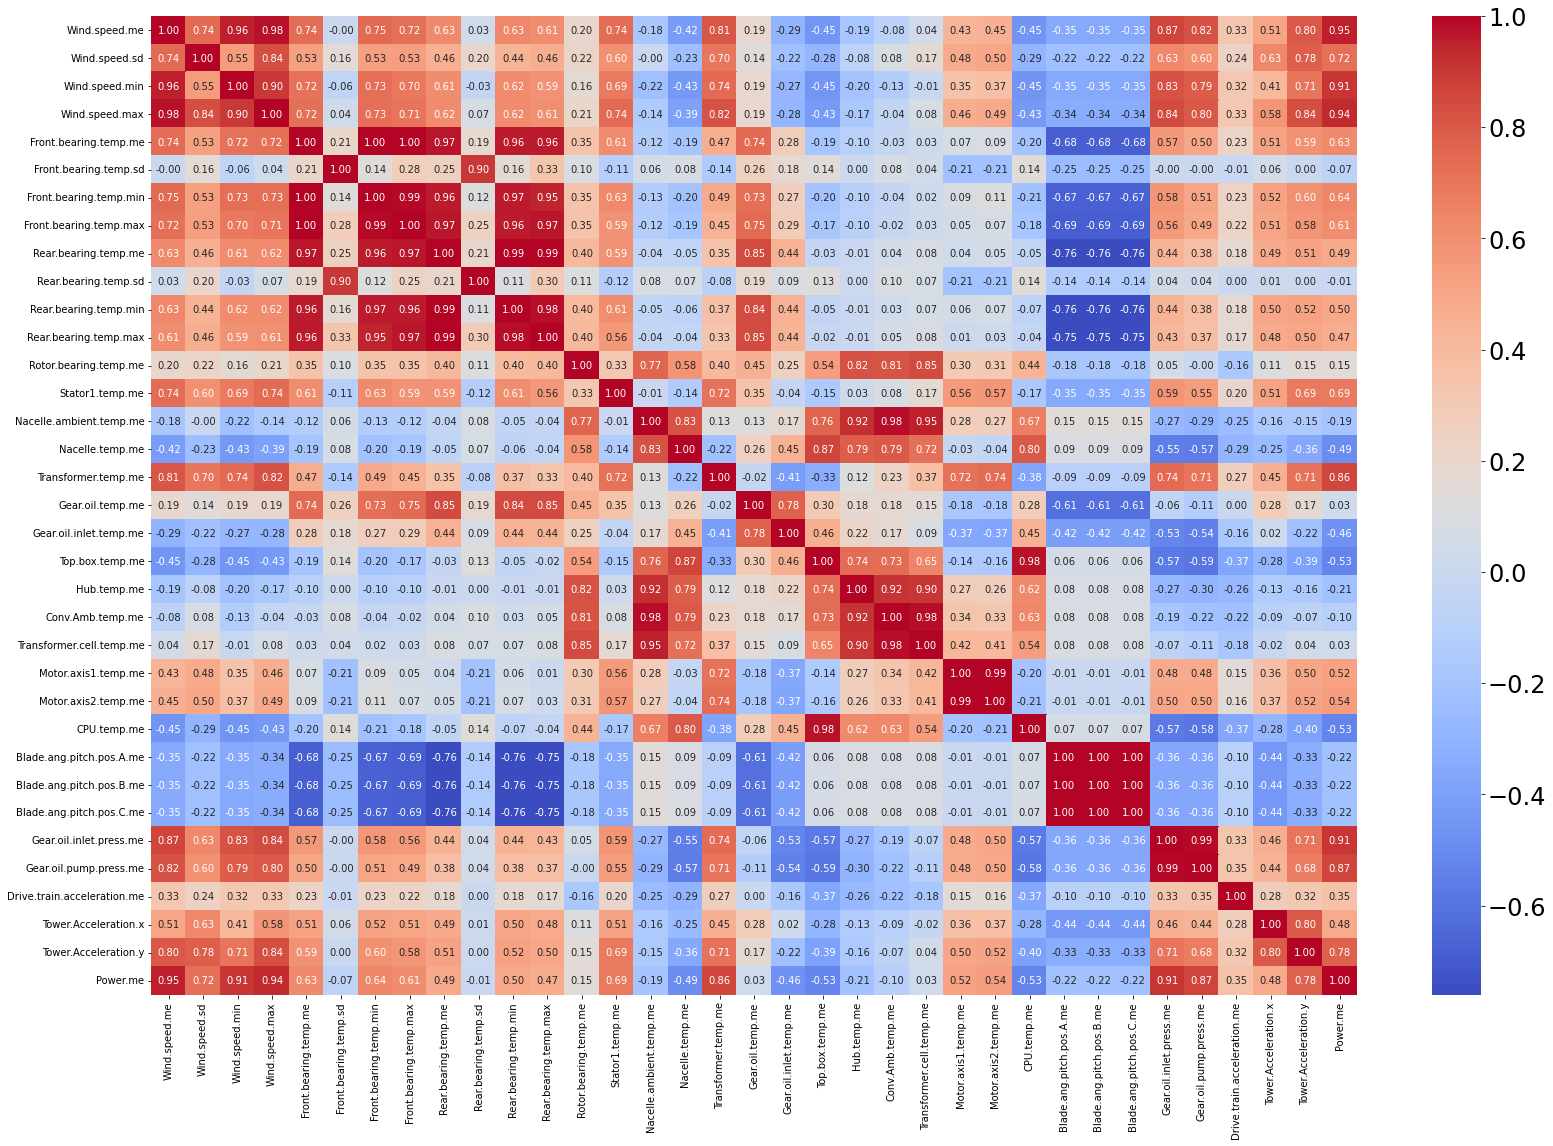

In [9]:
plt.figure(figsize=(27, 18))
correlation_matrix = df[features + [output_feature]].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

plt.show()

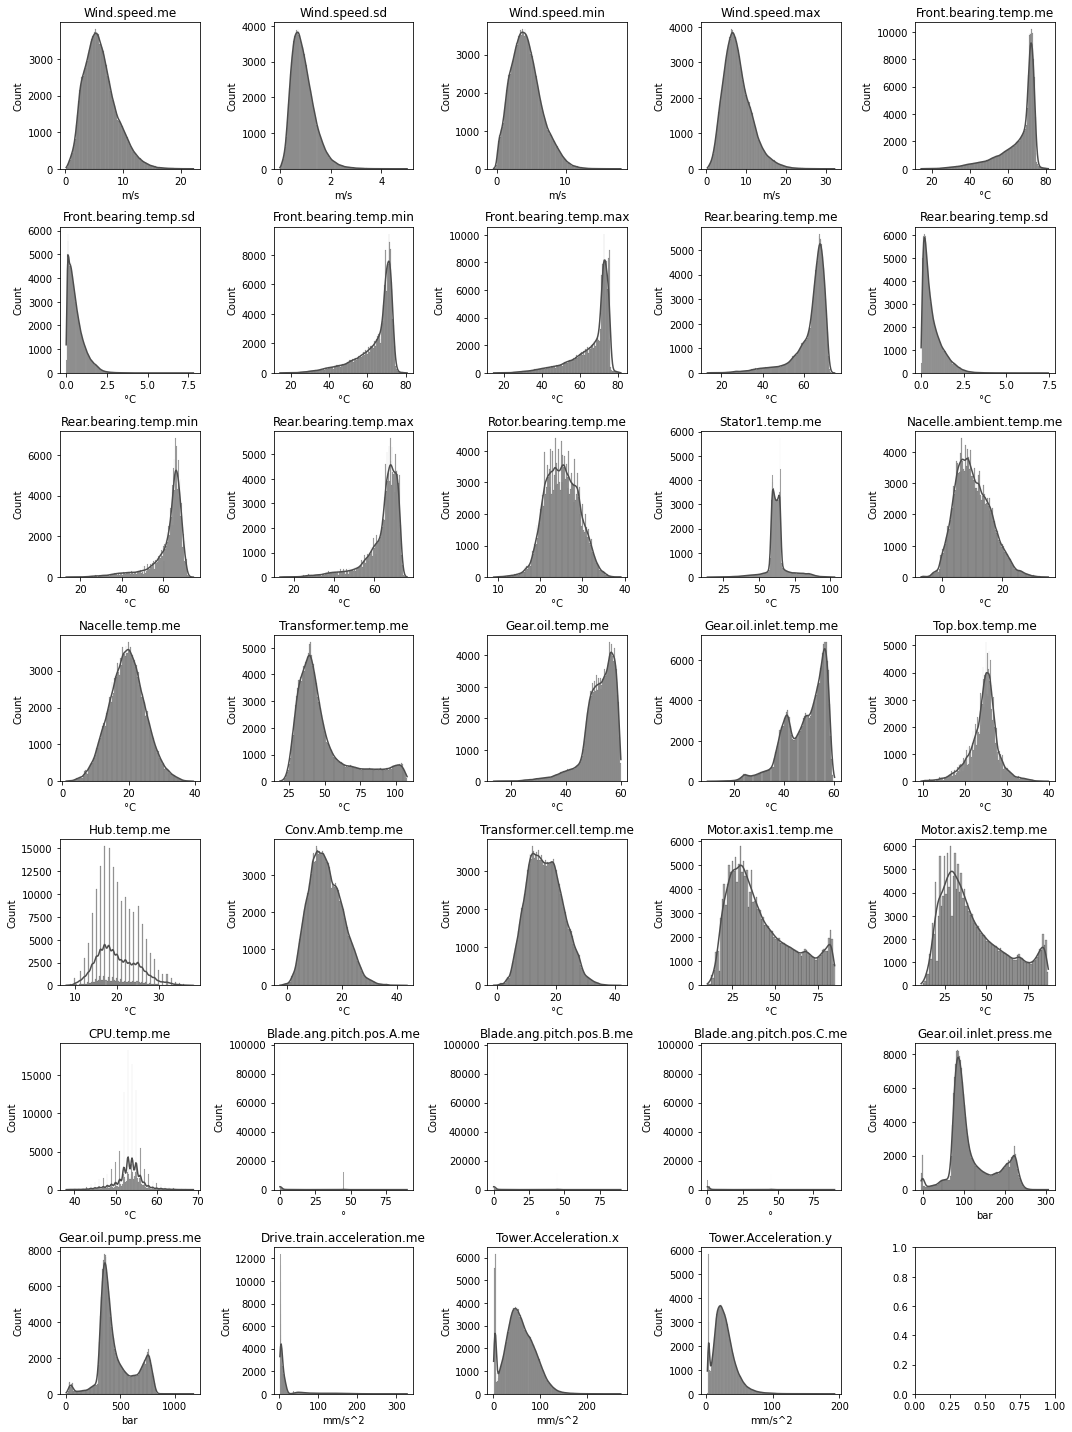

In [10]:
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i], color="0.3")
    axes[i].set_title(feature)
    axes[i].set_xlabel(units[feature])
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

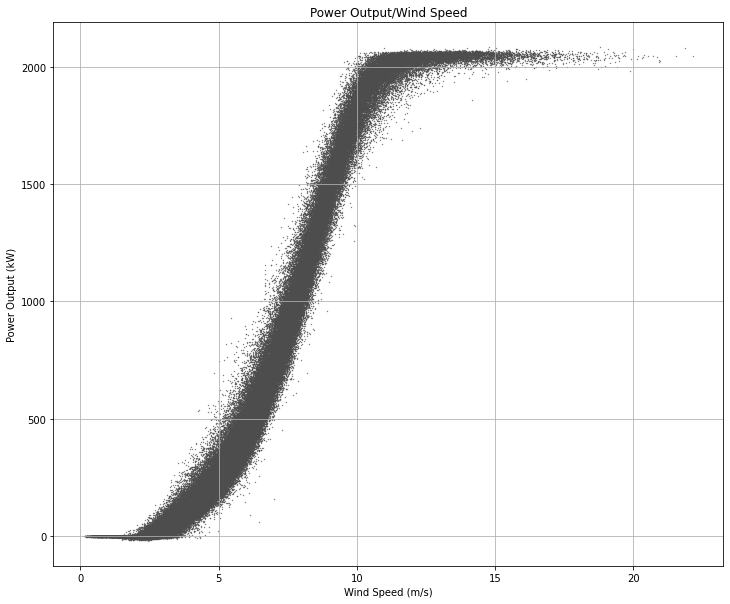

In [11]:
# Plot Power over Wind Speed
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

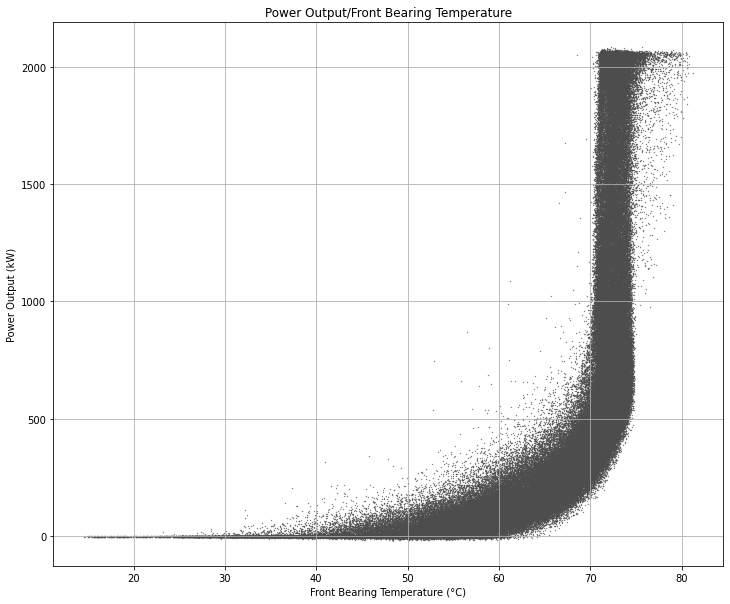

In [12]:
# Plot Power over Front Bearing Temperature
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

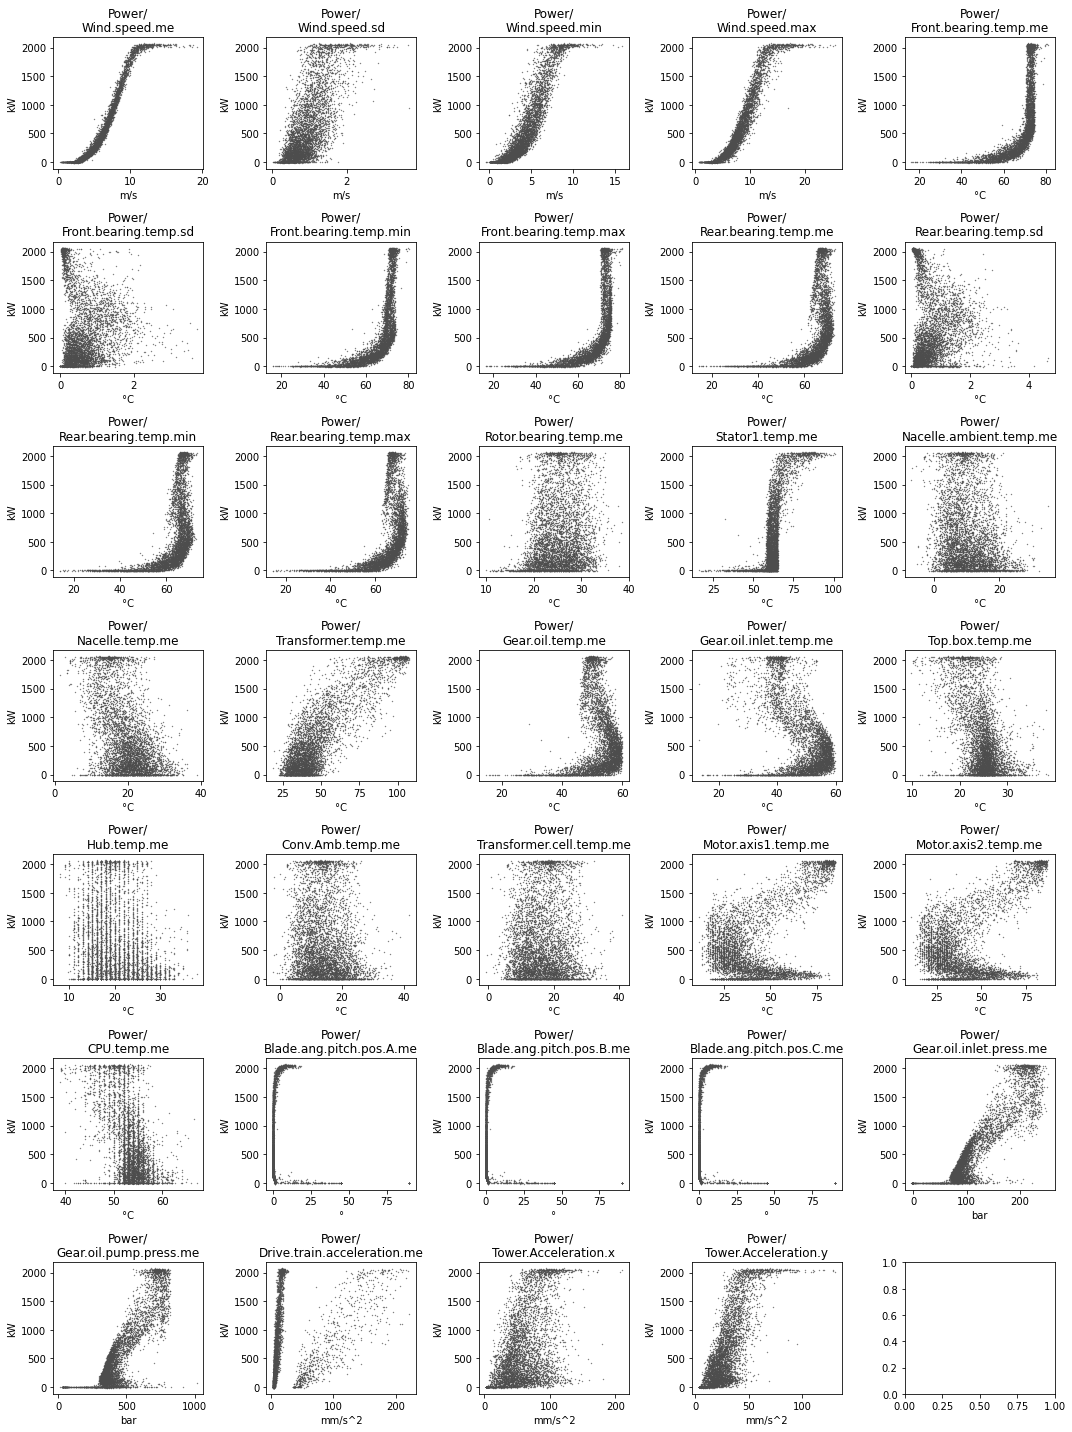

In [13]:
def plot_power_over_all_features(df, features, output_feature, sample_size=5000):
    df_sampled = df.sample(min(sample_size, len(df)))
    
    num_cols = 5
    num_rows = math.ceil(len(features) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        axes[i].scatter(x=df_sampled[feature], y=df_sampled[output_feature], alpha=0.7, color="0.3", linewidth=0, s=2)
        axes[i].set_title(f'Power/\n{feature}')
        axes[i].set_xlabel(units[feature])
        axes[i].set_ylabel('kW')

    plt.tight_layout()
    plt.show()
    
plot_power_over_all_features(df, features, output_feature, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [14]:
X_train, X_test, y_train, y_test, scaler = load_dataset_train_test_split(df, features, output_feature)

In [15]:
X_train.shape

(151504, 34)

In [16]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

In [128]:
# Set TRAIN to True if want to retrain the models
TRAIN = False

# Set EVALUATE_FEATURE_IMPORTANCE to True if want to evaluate the feature importance for the BNN model
EVALUATE_FEATURE_IMPORTANCE = False

In [18]:
results = {}

## Standard (Homoscedastic) Neural Networks

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [19]:
def create_model_mlp_non_probabilistic(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    hidden = Dense(80, activation="relu")(inputs)
    hidden = Dense(50, activation="relu")(hidden)
    hidden = Dense(20, activation="relu")(hidden)
    output = Dense(1, activation="linear")(hidden) 

    model_mlp_non_probabilistic = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model_mlp_non_probabilistic

model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train, MODELS_SEED)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 80)                2800      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7891 (30.82 KB)
Trainable params: 7891 (30.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
4262/4262 [====

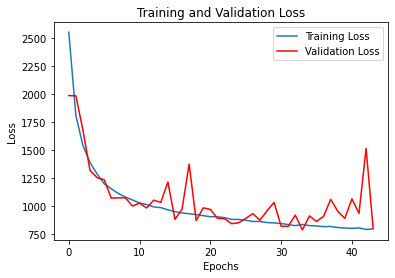

In [20]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic,
                          X_train, y_train,
                          patience=10, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [21]:
model_mlp_non_probabilistic.load_weights("saved_models/model_mlp_non_probabilistic.keras")

In [22]:
model_mlp_non_probabilistic.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 969us/step - loss: 785.7430


785.7429809570312

In [23]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_print_metrics(results, "Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

1184/1184 [==============================] - 1s 832us/step
Train RMSE: 27.453
Test RMSE: 28.031
Train MAE: 16.452
Test MAE: 16.765
Percentage of Train Data Points within 99.00% CI: 96.27%
Percentage of Test Data Points within 99.00% CI: 96.25%


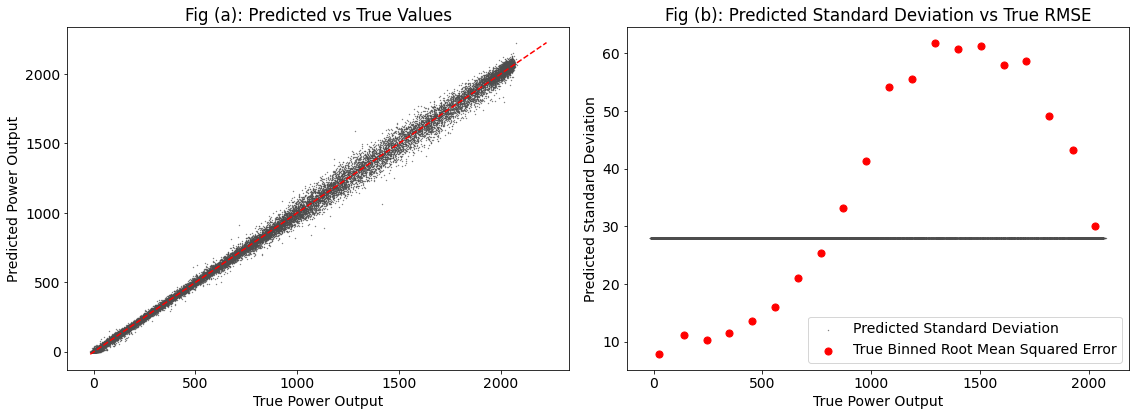

In [24]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

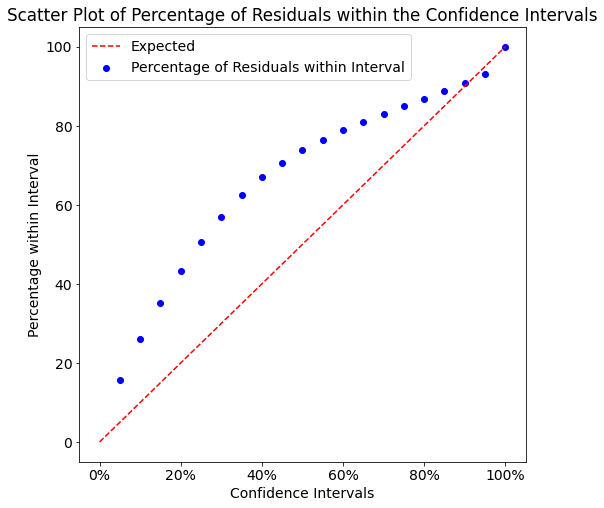

In [25]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [26]:
SAMPLE_PERCENTAGE = 0.01
np.random.seed(MODELS_SEED)

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [27]:
def create_model_mlp_non_probabilistic_bnn_flipout(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)
    
    output = tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)

    model_mlp_non_probabilistic_bnn = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic_bnn.compile(Adam(learning_rate=0.001), loss='mean_squared_error')

    return model_mlp_non_probabilistic_bnn

model_mlp_non_probabilistic_bnn_flipout_sample = create_model_mlp_non_probabilistic_bnn_flipout(X_train_sampled, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_flipout (DenseFlipou  (None, 30)                4110      
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 1)                 121       
 out)                                                            
                                                                 
Total params: 7861 (30.71 KB)
Trainable params: 7861 (30.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

Epoch 66/100
6/6 [==============================] - 0s 22ms/step - loss: 38370.4062 - val_loss: 36576.1641
Epoch 67/100
6/6 [==============================] - 0s 28ms/step - loss: 37005.5508 - val_loss: 34682.5469
Epoch 68/100
6/6 [==============================] - 0s 23ms/step - loss: 35110.6250 - val_loss: 34073.1055
Epoch 69/100
6/6 [==============================] - 0s 23ms/step - loss: 34166.5898 - val_loss: 32883.0078
Epoch 70/100
6/6 [==============================] - 0s 23ms/step - loss: 32775.8516 - val_loss: 31337.0918
Epoch 71/100
6/6 [==============================] - 0s 22ms/step - loss: 32266.8086 - val_loss: 31315.5996
Epoch 72/100
6/6 [==============================] - 0s 22ms/step - loss: 30816.1992 - val_loss: 29588.6016
Epoch 73/100
6/6 [==============================] - 0s 28ms/step - loss: 29926.1797 - val_loss: 28591.2930
Epoch 74/100
6/6 [==============================] - 0s 24ms/step - loss: 29219.0840 - val_loss: 28581.8711
Epoch 75/100
6/6 [===================

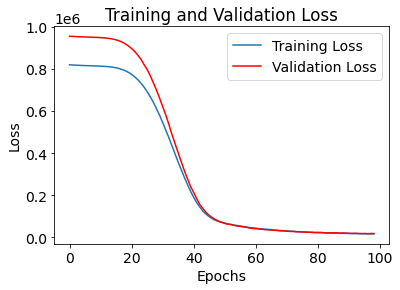

In [28]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout_sample,
                          X_train_sampled, y_train_sampled,
                          patience=20, epochs=100, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [29]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras")

In [30]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout_sample, X_train, X_test, num_samples=20)

1184/1184 [==============================] - 1s 1ms/step


In [31]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 124.985
Test RMSE: 124.925
Train MAE: 92.537
Test MAE: 92.370
Percentage of Train Data Points within 99.00% CI: 16.94%
Percentage of Test Data Points within 99.00% CI: 17.17%


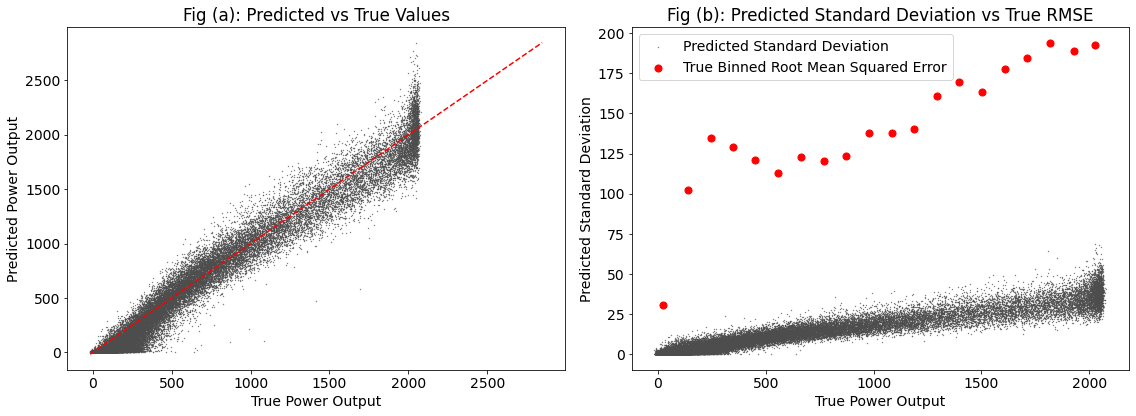

In [32]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

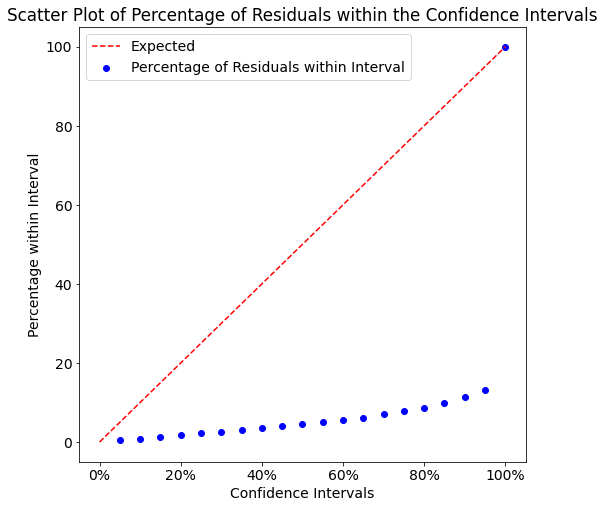

In [33]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [34]:
model_mlp_non_probabilistic_bnn_flipout = create_model_mlp_non_probabilistic_bnn_flipout(X_train, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_flipout_4 (DenseFlip  (None, 30)                4110      
 out)                                                            
                                                                 
 dense_flipout_5 (DenseFlip  (None, 30)                3630      
 out)                                                            
                                                                 
 dense_flipout_7 (DenseFlip  (None, 1)                 121       
 out)                                                            
                                                                 
Total params: 7861 (30.71 KB)
Trainable params: 7861 (30.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

533/533 [==============================] - 2s 4ms/step - loss: 1367.6820 - val_loss: 1385.3956
Epoch 67/400
533/533 [==============================] - 2s 4ms/step - loss: 1355.6626 - val_loss: 1363.1061
Epoch 68/400
533/533 [==============================] - 2s 4ms/step - loss: 1353.0845 - val_loss: 1376.5295
Epoch 69/400
533/533 [==============================] - 2s 4ms/step - loss: 1342.6649 - val_loss: 1364.7916
Epoch 70/400
533/533 [==============================] - 2s 4ms/step - loss: 1341.8248 - val_loss: 1390.6273
Epoch 71/400
533/533 [==============================] - 2s 4ms/step - loss: 1328.1655 - val_loss: 1361.4047
Epoch 72/400
533/533 [==============================] - 2s 4ms/step - loss: 1323.2904 - val_loss: 1352.5684
Epoch 73/400
533/533 [==============================] - 2s 4ms/step - loss: 1314.3003 - val_loss: 1327.8247
Epoch 74/400
533/533 [==============================] - 2s 4ms/step - loss: 1304.7140 - val_loss: 1323.4026
Epoch 75/400
533/533 [===================

533/533 [==============================] - 2s 3ms/step - loss: 1062.2400 - val_loss: 1119.1782
Epoch 142/400
533/533 [==============================] - 2s 4ms/step - loss: 1060.6880 - val_loss: 1136.4045
Epoch 143/400
533/533 [==============================] - 2s 4ms/step - loss: 1058.5258 - val_loss: 1102.8778
Epoch 144/400
533/533 [==============================] - 2s 4ms/step - loss: 1056.4265 - val_loss: 1098.7158
Epoch 145/400
533/533 [==============================] - 2s 4ms/step - loss: 1053.8860 - val_loss: 1095.3531
Epoch 146/400
533/533 [==============================] - 2s 4ms/step - loss: 1052.0197 - val_loss: 1095.8285
Epoch 147/400
533/533 [==============================] - 2s 4ms/step - loss: 1049.0918 - val_loss: 1081.2438
Epoch 148/400
533/533 [==============================] - 2s 4ms/step - loss: 1044.0509 - val_loss: 1084.8123
Epoch 149/400
533/533 [==============================] - 2s 4ms/step - loss: 1048.2723 - val_loss: 1089.8560
Epoch 150/400
533/533 [==========

Epoch 217/400
533/533 [==============================] - 2s 4ms/step - loss: 949.7072 - val_loss: 1000.7354
Epoch 218/400
533/533 [==============================] - 2s 4ms/step - loss: 946.8010 - val_loss: 996.6058
Epoch 219/400
533/533 [==============================] - 2s 4ms/step - loss: 945.4818 - val_loss: 982.0592
Epoch 220/400
533/533 [==============================] - 2s 4ms/step - loss: 945.2646 - val_loss: 995.0507
Epoch 221/400
533/533 [==============================] - 2s 4ms/step - loss: 943.8863 - val_loss: 1006.2820
Epoch 222/400
533/533 [==============================] - 2s 4ms/step - loss: 946.6553 - val_loss: 978.0673
Epoch 223/400
533/533 [==============================] - 2s 4ms/step - loss: 942.1024 - val_loss: 984.9094
Epoch 224/400
533/533 [==============================] - 2s 4ms/step - loss: 944.1381 - val_loss: 984.7254
Epoch 225/400
533/533 [==============================] - 2s 4ms/step - loss: 943.4066 - val_loss: 980.8817
Epoch 226/400
533/533 [============

533/533 [==============================] - 2s 4ms/step - loss: 903.1857 - val_loss: 972.8845


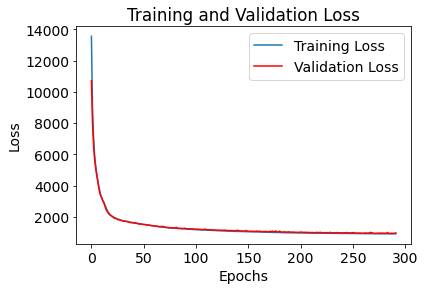

In [35]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout,
                          X_train, y_train,
                          patience=20, epochs=400, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [36]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout.keras")

In [37]:
model_mlp_non_probabilistic_bnn_flipout.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 1ms/step - loss: 916.1118


916.11181640625

In [38]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout, X_train, X_test, num_samples=20)

1184/1184 [==============================] - 2s 1ms/step


In [39]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, "Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 29.780
Test RMSE: 30.081
Train MAE: 18.399
Test MAE: 18.492
Percentage of Train Data Points within 99.00% CI: 24.50%
Percentage of Test Data Points within 99.00% CI: 24.57%


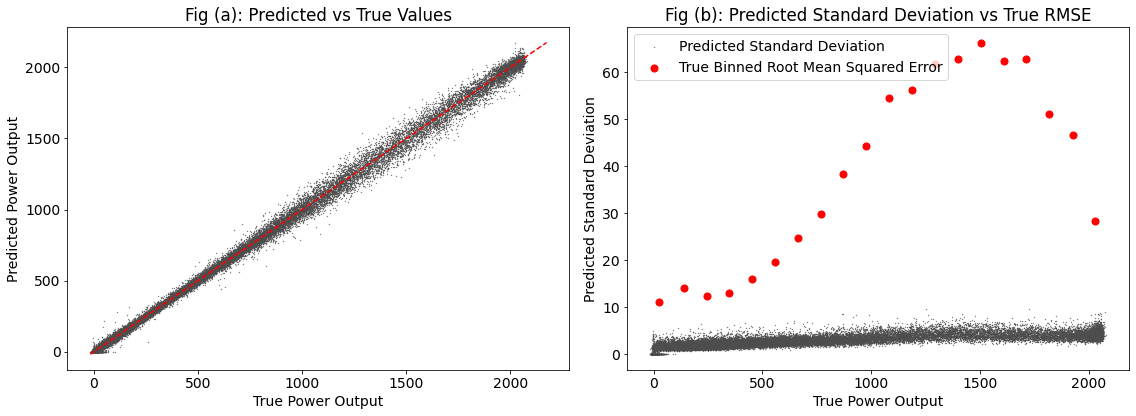

In [40]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

<ipython-input-2-edb2510a773c>:88: RuntimeWarning: invalid value encountered in multiply
  lower_bounds = y_test_pred.ravel() - t_value * y_test_std
<ipython-input-2-edb2510a773c>:89: RuntimeWarning: invalid value encountered in multiply
  upper_bounds = y_test_pred.ravel() + t_value * y_test_std


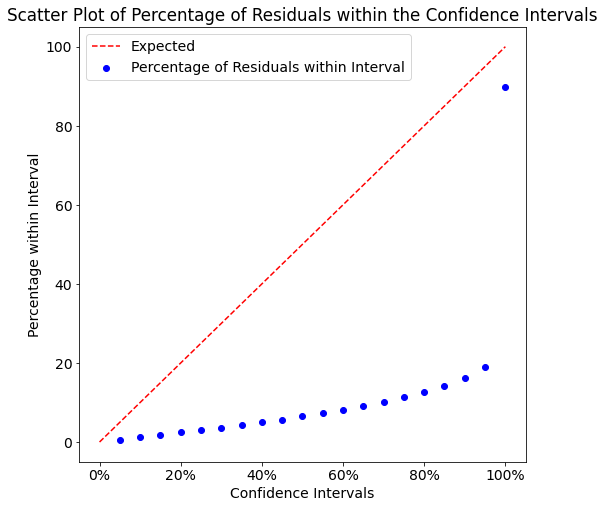

In [41]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

##### Feature Importance

For the interest of the field we evaluate the raw feature importance within the Bayesian network. Let's evaluate feature importance for the BNN with deterministic output. We do this only for the deterministic output because the RATE library does not support probabilistic regressions (see https://github.com/lorinanthony/RATE). To do so we retrain the model wrapped into a BNN_Regressor class from the RATE library.

In [42]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    p = X_test.shape[1]

    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

    layers = []

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            input_shape=(p,),
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "linear"
        ))

    bnn = BNN_Regressor(layers, p=p)
    fit_history = bnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                        verbose=0)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    ratings = RATE_BNN(bnn, X_test_sampled, n_workers=1)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    rates = RATE_BNN(bnn, X_test_sampled, n_workers=1)
    feature_importance = {feature: rate for feature, rate in zip(features, list(rates[0]))}

In [43]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())

    plt.figure(figsize=(10, 12))
    plt.barh(features, importance_values, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')

    for i, importance in enumerate(importance_values):
        plt.text(importance, i, f'{importance*100:.2f}', va='center')

    plt.xlim(0, max(importance_values) + 0.02)
    plt.tight_layout()
    plt.show()

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [44]:
def create_model_bnn(X_train, seed):
    keras.utils.set_random_seed(seed) 
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
        
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=80,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=50,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    # Output Univariate Normal Probabilistic Layer
    dist_params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(dist_params)

    model_bnn = Model(inputs=inputs, outputs=dist)
    model_bnn.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_bnn

model_bnn = create_model_bnn(X_train, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_flipout_8 (DenseFlip  (None, 80)                10960     
 out)                                                            
                                                                 
 dense_flipout_9 (DenseFlip  (None, 50)                16050     
 out)                                                            
                                                                 
 dense_flipout_10 (DenseFli  (None, 20)                4020      
 pout)                                                           
                                                                 
 dense_4 (Dense)             (None, 2)                 42        
                                                           

533/533 [==============================] - 2s 5ms/step - loss: 4.0568 - val_loss: 4.0718
Epoch 67/100
533/533 [==============================] - 2s 5ms/step - loss: 4.0422 - val_loss: 4.0537
Epoch 68/100
533/533 [==============================] - 3s 5ms/step - loss: 4.0342 - val_loss: 4.0517
Epoch 69/100
533/533 [==============================] - 2s 5ms/step - loss: 4.0261 - val_loss: 4.0414
Epoch 70/100
533/533 [==============================] - 2s 5ms/step - loss: 4.0188 - val_loss: 4.0474
Epoch 71/100
533/533 [==============================] - 2s 4ms/step - loss: 4.0085 - val_loss: 4.0347
Epoch 72/100
533/533 [==============================] - 2s 4ms/step - loss: 4.0025 - val_loss: 4.0266
Epoch 73/100
533/533 [==============================] - 2s 5ms/step - loss: 3.9950 - val_loss: 4.0172
Epoch 74/100
533/533 [==============================] - 3s 5ms/step - loss: 3.9870 - val_loss: 4.0030
Epoch 75/100
533/533 [==============================] - 3s 5ms/step - loss: 3.9794 - val_loss: 

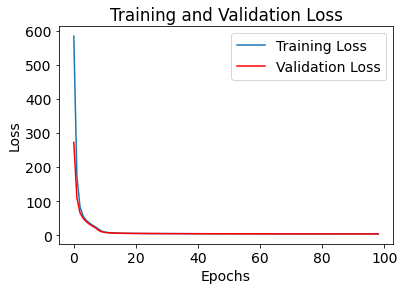

In [45]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_bnn.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_bnn,
                          X_train, y_train,
                          patience=10, epochs=100, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [46]:
model_bnn.load_weights("saved_models/model_bnn.keras")

In [47]:
model_bnn.evaluate(X_test, y_test)

1184/1184 [==============================] - 2s 2ms/step - loss: 3.8706


3.8705666065216064

In [48]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Aleatoric & Epistemic Uncertainty BNN (Flipout)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 29.884
Test RMSE: 30.303
Train MAE: 16.359
Test MAE: 16.563
Percentage of Train Data Points within 99.00% CI: 98.41%
Percentage of Test Data Points within 99.00% CI: 98.18%


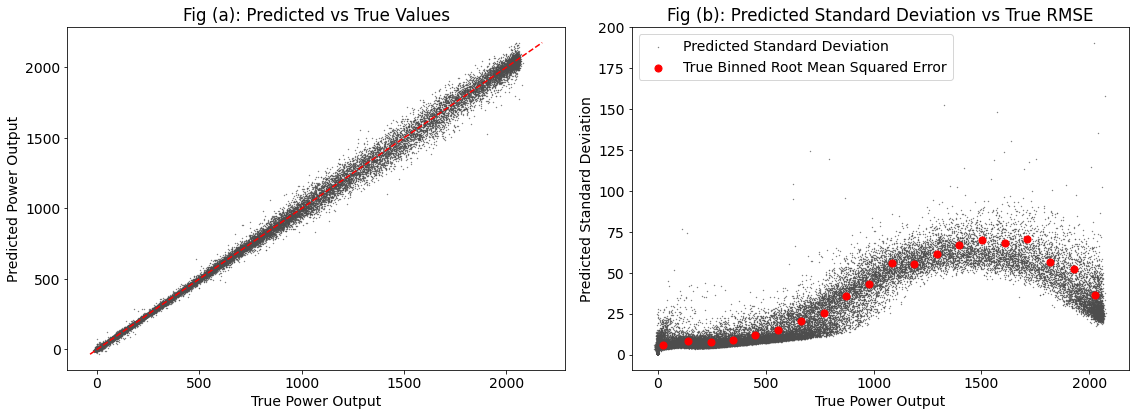

In [49]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

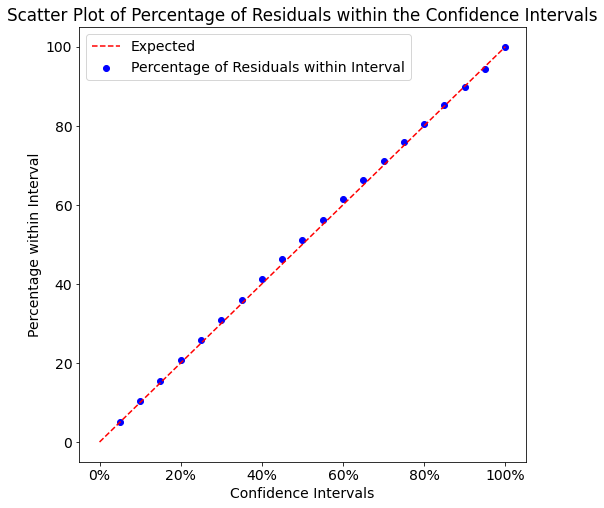

In [50]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

## Non-Bayesian
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### Deep Neural Network with Gaussian Output (Separate Submodels)

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [51]:
def create_model_mlp_gaussian_separate(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    mean_h1 = Dense(80, activation="relu")(inputs)
    variance_h1 = Dense(80, activation="relu")(inputs)
    
    mean_h2 = Dense(50, activation="relu")(mean_h1)
    variance_h2 = Dense(50, activation="relu")(variance_h1)
    
    mean_h3 = Dense(20, activation="relu")(mean_h2)
    variance_h3 = Dense(20, activation="relu")(variance_h2)
    
    mean_h4 = Dense(20, activation="relu")(mean_h3)
    variance_h4 = Dense(20, activation="relu")(variance_h3)
    
    mean_out = Dense(1)(mean_h4)
    variance_out = Dense(1)(variance_h4)
    
    params = Concatenate()([mean_out, variance_out])
    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train, MODELS_SEED)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 80)                   2800      ['input_5[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 80)                   2800      ['input_5[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 50)                   4050      ['dense_5[0][0]']             
                                                                                            

4262/4262 [==============================] - 7s 2ms/step - loss: 3.8196 - val_loss: 3.8160
Epoch 48/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.8186 - val_loss: 3.8352
Epoch 49/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8149 - val_loss: 3.8753
Epoch 50/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.8171 - val_loss: 3.8332
Epoch 51/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8096 - val_loss: 3.9106
Epoch 52/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8044 - val_loss: 3.7677
Epoch 53/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.8023 - val_loss: 3.8253
Epoch 54/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8012 - val_loss: 3.8122
Epoch 55/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8012 - val_loss: 3.8191
Epoch 56/100
4262/4262 [==============================] - 8s 2ms/step - loss:

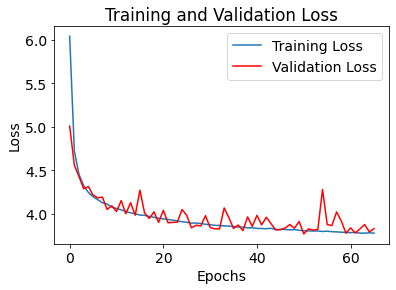

In [52]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_separate.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_separate,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [53]:
model_mlp_gaussian_separate.load_weights("saved_models/model_mlp_gaussian_separate.keras")

In [54]:
model_mlp_gaussian_separate.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 1ms/step - loss: 3.7626


3.762573480606079

In [55]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 28.267
Test RMSE: 28.872
Train MAE: 15.195
Test MAE: 15.434
Percentage of Train Data Points within 99.00% CI: 99.14%
Percentage of Test Data Points within 99.00% CI: 98.92%


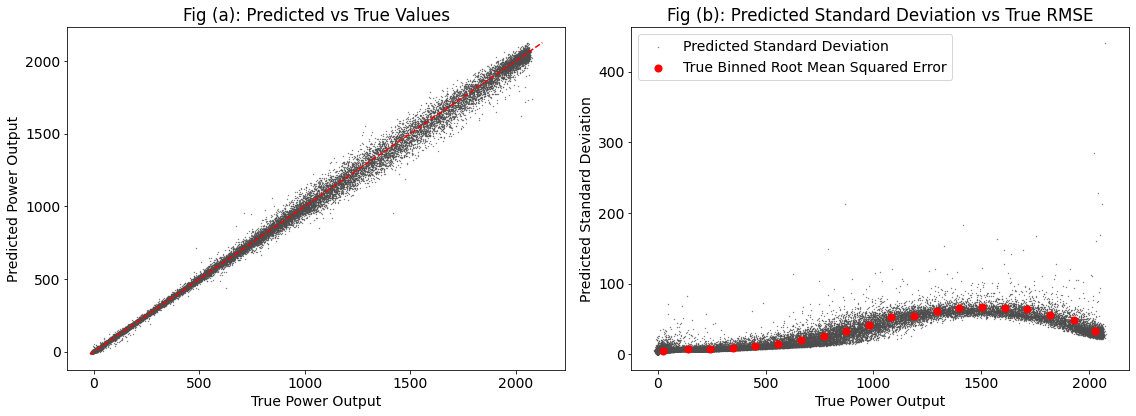

In [56]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

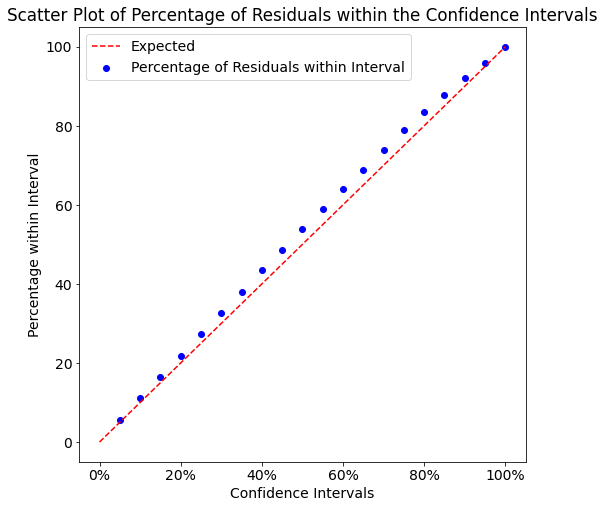

In [57]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

### Deep Neural Network with Gaussian Output (Joint Submodels)

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [58]:
def create_model_mlp_gaussian_joint(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 100)                  3500      ['input_6[0][0]']             
                                                                                                  
 dense_16 (Dense)            (None, 80)                   8080      ['dense_15[0][0]']            
                                                                                                  
 dense_17 (Dense)            (None, 40)                   3240      ['dense_16[0][0]']            
                                                                                            

4262/4262 [==============================] - 7s 2ms/step - loss: 3.7637 - val_loss: 3.7756
Epoch 52/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.7592 - val_loss: 3.7877
Epoch 53/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7598 - val_loss: 3.8419
Epoch 54/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7572 - val_loss: 3.8021
Epoch 55/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7547 - val_loss: 3.8134
Epoch 56/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.7552 - val_loss: 4.0481
Epoch 57/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7551 - val_loss: 3.9930
Epoch 58/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7512 - val_loss: 3.8491
Epoch 59/100
4262/4262 [==============================] - 6s 1ms/step - loss: 3.7489 - val_loss: 3.8859
Epoch 60/100
4262/4262 [==============================] - 7s 2ms/step - loss:

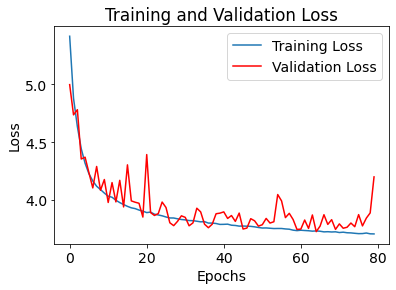

In [59]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_joint.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [60]:
model_mlp_gaussian_joint.load_weights("saved_models/model_mlp_gaussian_joint.keras")

In [61]:
model_mlp_gaussian_joint.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 1ms/step - loss: 3.7162


3.716238260269165

In [62]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Joint Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 25.897
Test RMSE: 26.630
Train MAE: 14.067
Test MAE: 14.439
Percentage of Train Data Points within 99.00% CI: 99.11%
Percentage of Test Data Points within 99.00% CI: 98.83%


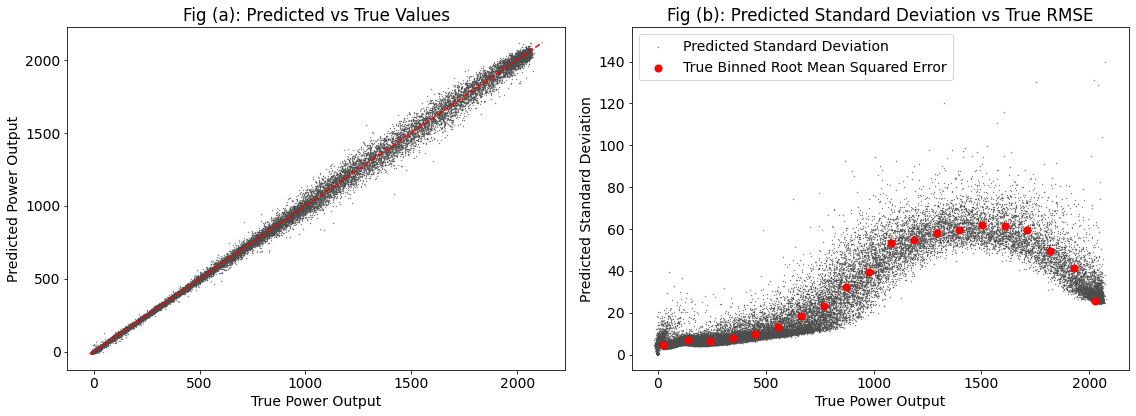

In [63]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

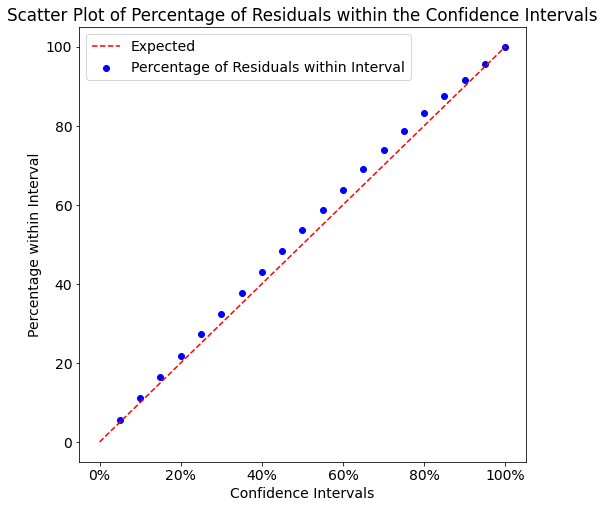

In [64]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

By comparing the two architecture it is clear that a separate set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the first. 

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [65]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [66]:
def create_model_cnn_gaussian(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    conv1d_layer = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
    maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
    
    flatten_layer = Flatten()(maxpooling_layer)
 
    hidden1 = Dense(50, activation="relu")(flatten_layer)
    hidden2 = Dense(50, activation="relu")(hidden1)
    hidden3 = Dense(20, activation="relu")(hidden2)
    
    params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_cnn_gaussian = Model(inputs=inputs, outputs=dist)
    model_cnn_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)
    
    return model_cnn_gaussian

model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn, MODELS_SEED)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 34, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense_23 (Dense)            (None, 50)                24050     
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                           

4262/4262 [==============================] - 12s 3ms/step - loss: 3.9310 - val_loss: 3.9447
Epoch 63/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.9279 - val_loss: 3.9076
Epoch 64/100
4262/4262 [==============================] - 13s 3ms/step - loss: 3.9196 - val_loss: 3.9115
Epoch 65/100
4262/4262 [==============================] - 11s 3ms/step - loss: 3.9154 - val_loss: 3.9193
Epoch 66/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.9201 - val_loss: 3.8946
Epoch 67/100
4262/4262 [==============================] - 10s 2ms/step - loss: 3.9106 - val_loss: 3.8977
Epoch 68/100
4262/4262 [==============================] - 10s 2ms/step - loss: 3.9063 - val_loss: 4.0258
Epoch 69/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.9086 - val_loss: 3.9757
Epoch 70/100
4262/4262 [==============================] - 16s 4ms/step - loss: 3.9032 - val_loss: 4.0977
Epoch 71/100
4262/4262 [==============================] - 17s 4ms/step

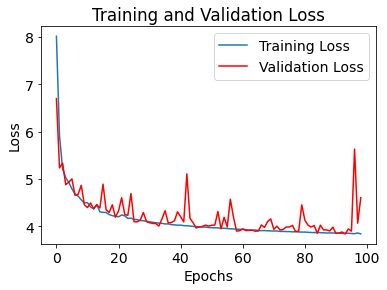

In [67]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_cnn_gaussian.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_cnn_gaussian,
                          X_train_cnn, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [68]:
model_cnn_gaussian.load_weights("saved_models/model_cnn_gaussian.keras")

In [69]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

1184/1184 [==============================] - 2s 1ms/step - loss: 4.5749


4.574850559234619

In [70]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

Train RMSE: 34.357
Test RMSE: 35.254
Train MAE: 21.671
Test MAE: 22.119
Percentage of Train Data Points within 99.00% CI: 90.76%
Percentage of Test Data Points within 99.00% CI: 90.37%


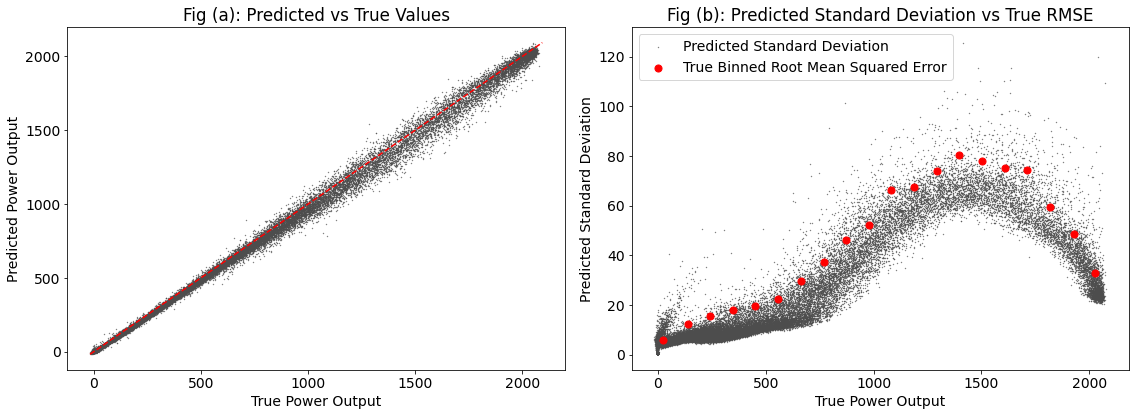

In [71]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

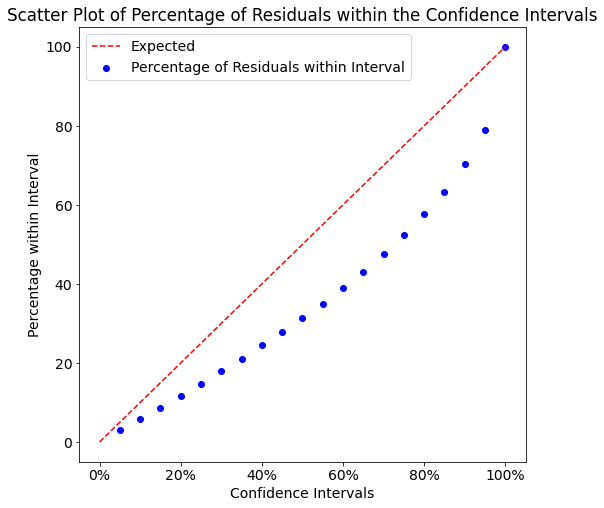

In [72]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the Convolution layer have little significance. 

### Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [73]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [74]:
def train_multivariate_model(model, X_train, y_train, epochs, batch_size, patience, cp_callback):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.build(X_train.shape)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, cp_callback]
    )

    return history

In [75]:
# Specify the number of turbines to consider
turbine_num = 6

# Select the n turbines with the most common non-NaN data points
turbine_counts = df_full.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_n = df_full[df_full['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_n, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [76]:
df_multivariate.head()

Wind.speed.me_1  Wind.speed.me_2  Wind.speed.me_3  \
Date.time                                                                
2017-09-25 00:00:00         5.171129         4.757817         4.175850   
2017-09-25 00:10:00         5.090679         4.150517         4.813357   
2017-09-25 00:20:00         5.193162         4.944641         4.449074   
2017-09-25 00:30:00         4.995740         5.542314         3.575596   
2017-09-25 00:40:00         5.111104         5.335591         4.376520   

                     Wind.speed.me_4  Wind.speed.me_5  Wind.speed.me_6  \
Date.time                                                                
2017-09-25 00:00:00         4.738792         4.758976         4.289168   
2017-09-25 00:10:00         4.977407         5.053728         4.628090   
2017-09-25 00:20:00         5.095903         4.834767         4.549418   
2017-09-25 00:30:00         4.835490         4.909376         4.255482   
2017-09-25 00:40:00         4.976042         4.800600         4.402867   

                     Wind.speed.sd_1  Wind.speed.sd_2  Wind.speed.sd_3  \
Date.time                                                                
2017-09-25 00:00:00         0.390980         0.372854         0.743623   
2017-09-25 00:10:00         0.436131         0.481464         0.531176   
2017-09-25 00:20:00         0.305424         0.624760         0.573716   
2017-09-25 00:30:00         0.258361         0.436264         0.536631   
2017-09-25 00:40:00         0.296016         0.385295         0.902530   

                     Wind.speed.sd_4  Wind.speed.sd_5  Wind.speed.sd_6  \
Date.time                                                                
2017-09-25 00:00:00         0.430659         0.470051         0.310066   
2017-09-25 00:10:00         0.283841         0.455439         0.441148   
2017-09-25 00:20:00         0.404364         0.438846         0.497882   
2017-09-25 00:30:00         0.299969         0.403833         0.432935   
2017-09-25 00:40:00         0.291973         0.485835         0.385300   

                     Wind.speed.min_1  Wind.speed.min_2  Wind.speed.min_3  \
Date.time                                                                   
2017-09-25 00:00:00          4.240140          4.072932          3.108902   
2017-09-25 00:10:00          4.303428          3.237551          3.791599   
2017-09-25 00:20:00          4.739578          3.796388          3.076056   
2017-09-25 00:30:00          4.488607          4.738413          2.526803   
2017-09-25 00:40:00          4.674517          4.606429          3.033590   

                     Wind.speed.min_4  Wind.speed.min_5  Wind.speed.min_6  \
Date.time                                                                   
2017-09-25 00:00:00          4.021239          3.839334          3.719075   
2017-09-25 00:10:00          4.610759          4.297034          4.070392   
2017-09-25 00:20:00          4.493885          3.727230          3.312805   
2017-09-25 00:30:00          4.406585          3.910666          3.526326   
2017-09-25 00:40:00          4.271038          4.098299          3.900779   

                     Wind.speed.max_1  Wind.speed.max_2  Wind.speed.max_3  \
Date.time                                                                   
2017-09-25 00:00:00          5.912565          5.788143          5.526302   
2017-09-25 00:10:00          5.930200          4.728431          5.550539   
2017-09-25 00:20:00          5.894996          6.286856          5.410614   
2017-09-25 00:30:00          5.601314          6.424064          4.927535   
2017-09-25 00:40:00          5.677069          6.162595          5.830315   

                     Wind.speed.max_4  Wind.speed.max_5  Wind.speed.max_6  \
Date.time                                                                   
2017-09-25 00:00:00          5.713630          5.655419          4.900722   
2017-09-25 00:10:00          5.693741          5.879260          5.641960   
2017-09-25 00:20:

In [77]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [78]:
print(X_train_mult.shape, y_train_mult.shape)

(73060, 204) (73060, 6)


In [79]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

Number of turbines considered in the prediction:  6


#### Diagonal Covariance Matrix (Separate branches for separate turbines)

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. 

In [80]:
def create_model_multivariate_gaussian_only_diagonal(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []

    for i in range(d):
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        out = Dense(2)(Concatenate()([h_means3, h_cov3]))
        outs.append(out)

    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],), MODELS_SEED)

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 204)]                0         []                            
                                                                                                  
 dense_27 (Dense)            (None, 50)                   10250     ['input_8[0][0]']             
                                                                                                  
 dense_28 (Dense)            (None, 50)                   10250     ['input_8[0][0]']             
                                                                                                  
 dense_34 (Dense)            (None, 50)                   10250     ['input_8[0][0]']             
                                                              

 concatenate_4 (Concatenate  (None, 40)                   0         ['dense_45[0][0]',            
 )                                                                   'dense_46[0][0]']            
                                                                                                  
 concatenate_5 (Concatenate  (None, 40)                   0         ['dense_52[0][0]',            
 )                                                                   'dense_53[0][0]']            
                                                                                                  
 concatenate_6 (Concatenate  (None, 40)                   0         ['dense_59[0][0]',            
 )                                                                   'dense_60[0][0]']            
                                                                                                  
 concatenate_7 (Concatenate  (None, 40)                   0         ['dense_66[0][0]',            
 )        

2055/2055 [==============================] - 7s 3ms/step - loss: 5251.9897 - val_loss: 30094.6309
Epoch 44/100
2055/2055 [==============================] - 8s 4ms/step - loss: 15524.3330 - val_loss: 27.9373
Epoch 45/100
2055/2055 [==============================] - 7s 4ms/step - loss: 27.0816 - val_loss: 27.7316
Epoch 46/100
2055/2055 [==============================] - 8s 4ms/step - loss: 27.3851 - val_loss: 27.3561
Epoch 47/100
2055/2055 [==============================] - 7s 3ms/step - loss: 27.2572 - val_loss: 27.2469
Epoch 48/100
2055/2055 [==============================] - 7s 4ms/step - loss: 26.7199 - val_loss: 27.1430
Epoch 49/100
2055/2055 [==============================] - 7s 3ms/step - loss: 26.6324 - val_loss: 26.9506
Epoch 50/100
2055/2055 [==============================] - 7s 4ms/step - loss: 26.3959 - val_loss: 26.8508
Epoch 51/100
2055/2055 [==============================] - 7s 3ms/step - loss: 26.3056 - val_loss: 26.6098
Epoch 52/100
2055/2055 [===========================

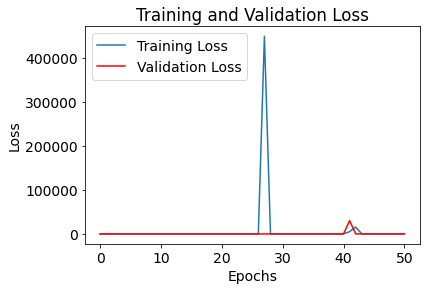

In [81]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_only_diagonal.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)
    
    plot_loss_history(history)

In [82]:
model_multivariate_gaussian_only_diagonal.load_weights("saved_models/model_multivariate_gaussian_only_diagonal.keras")

In [83]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 1s 2ms/step - loss: 26.1190


26.119016647338867

In [84]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 33.452
Test RMSE: 34.893
Train MAE: 20.796
Test MAE: 21.732
Percentage of Train Data Points within 99.00% CI: 99.06%
Percentage of Test Data Points within 99.00% CI: 98.66%


In [85]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

Turbine #1 - RMSE: 32.70829618570855
Turbine #2 - RMSE: 33.69230680117522
Turbine #3 - RMSE: 37.98010803434498
Turbine #4 - RMSE: 36.02208525452382
Turbine #5 - RMSE: 32.65427824986041
Turbine #6 - RMSE: 35.96825376601473


Turbine #1:


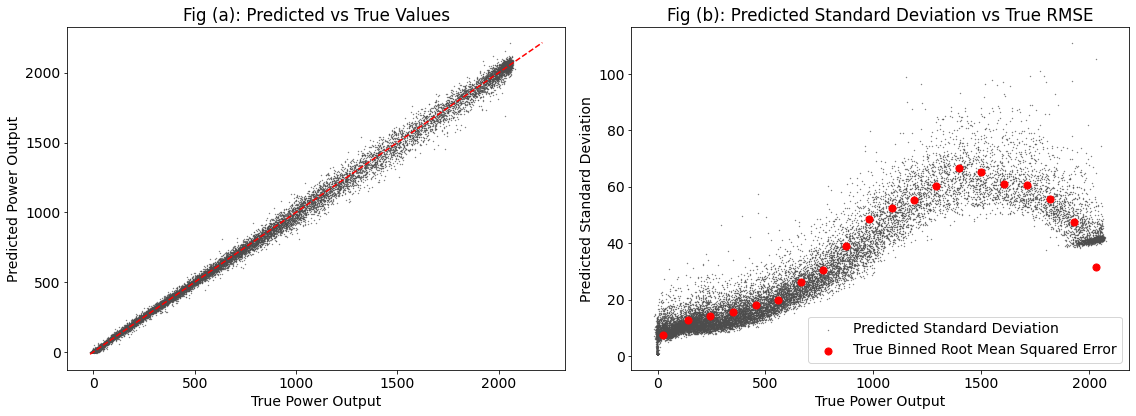

Turbine #2:


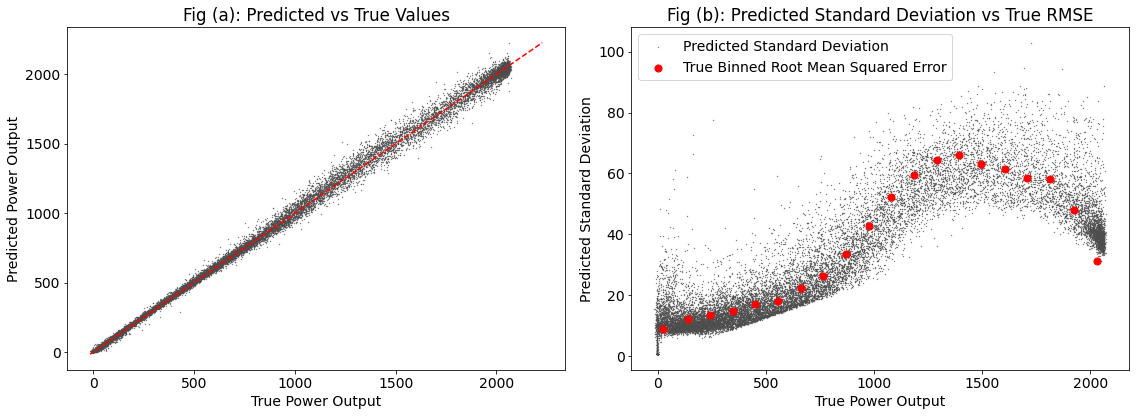

Turbine #3:


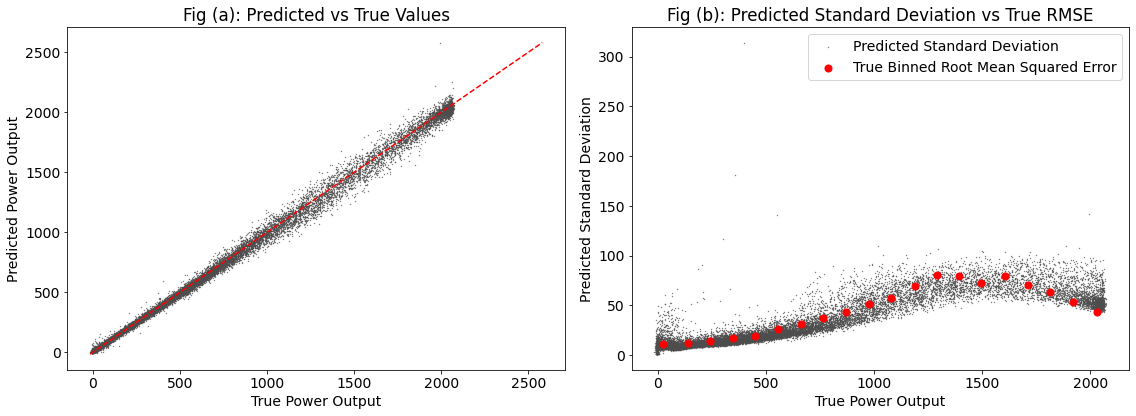

Turbine #4:


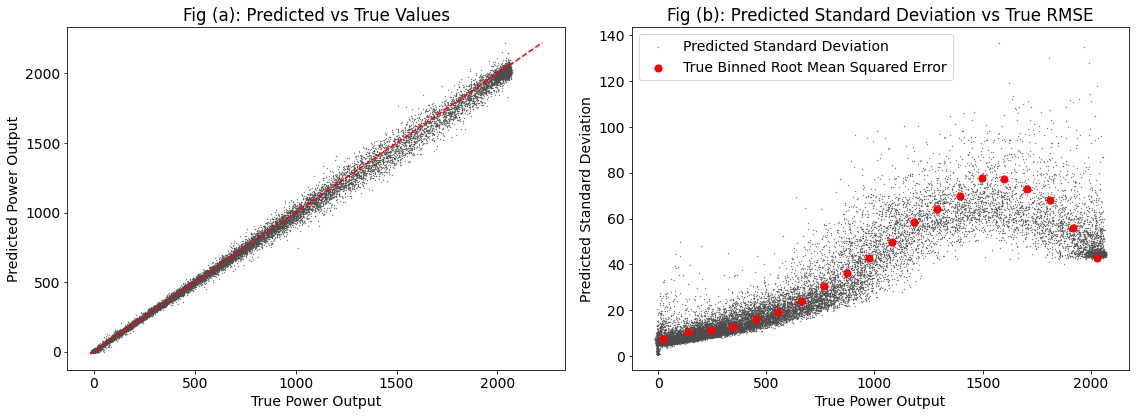

Turbine #5:


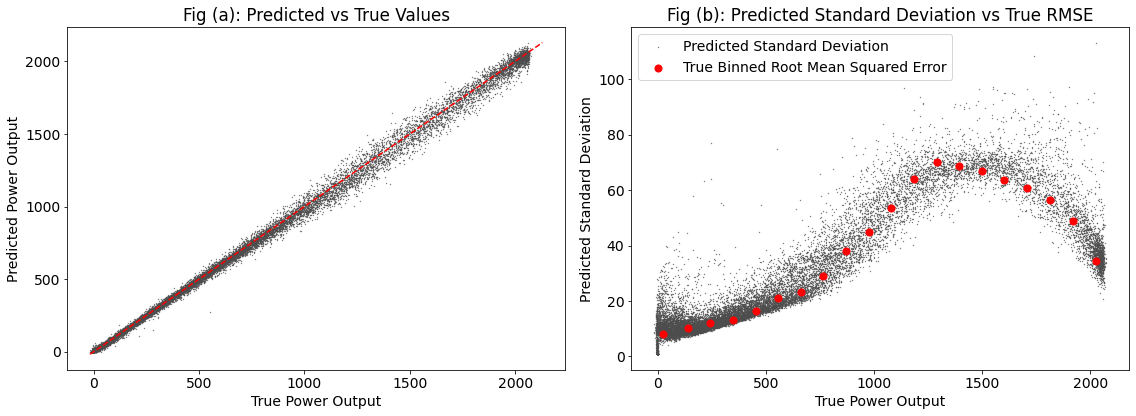

Turbine #6:


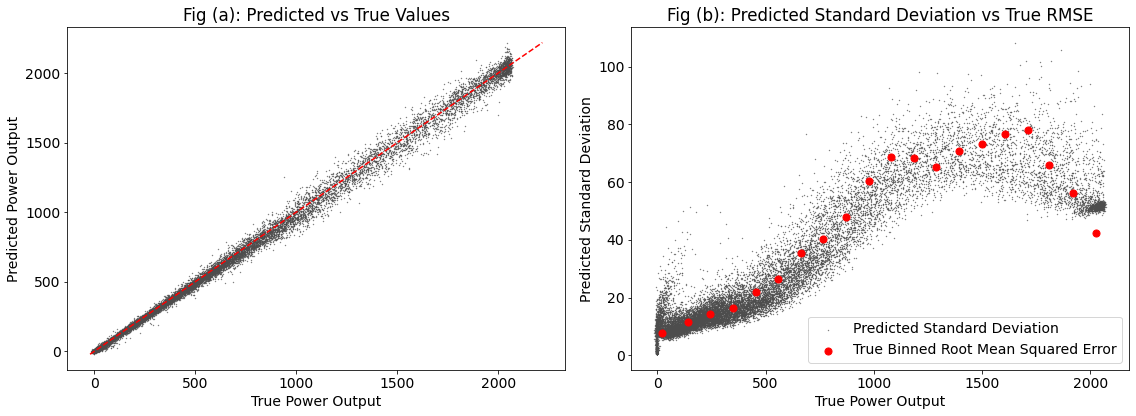

In [86]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


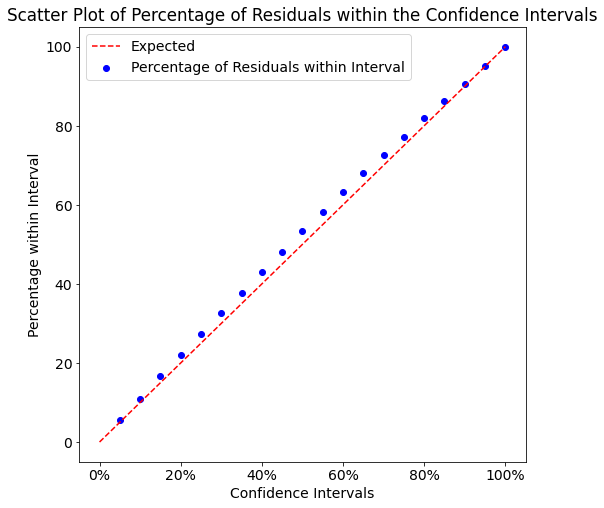

Turbine #2:


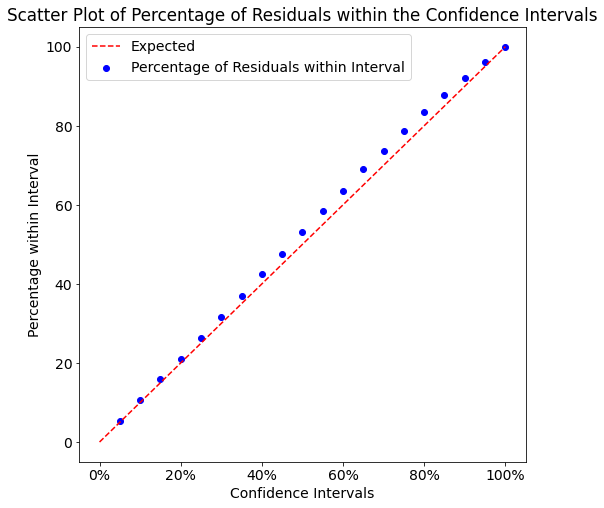

Turbine #3:


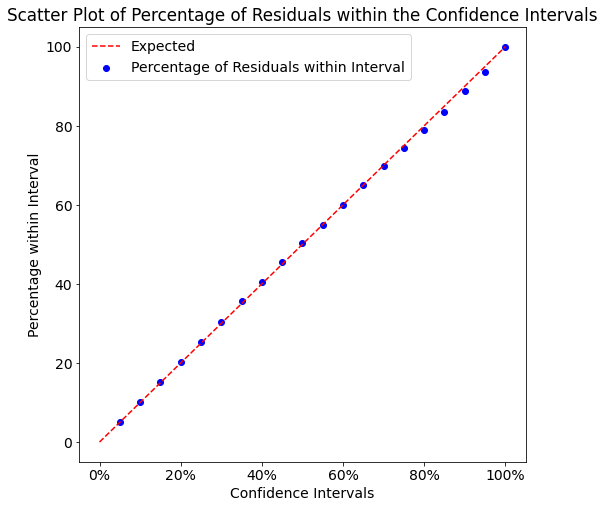

Turbine #4:


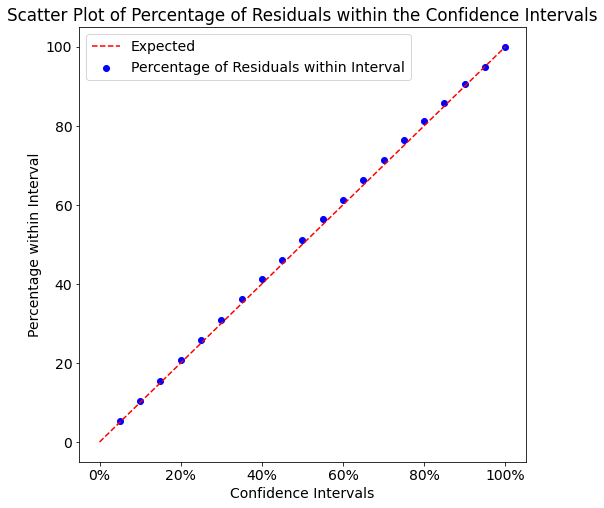

Turbine #5:


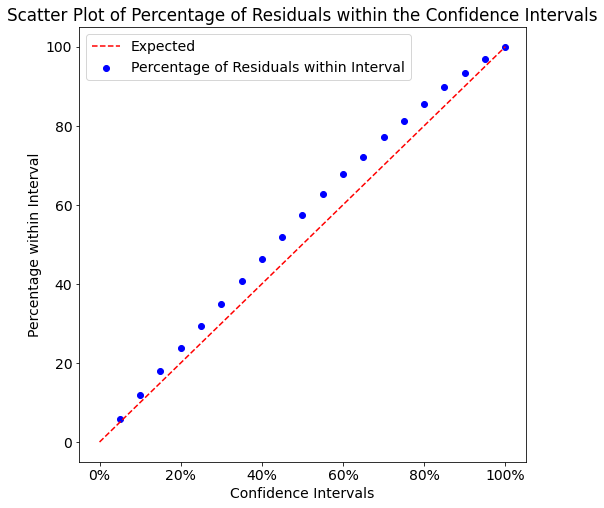

Turbine #6:


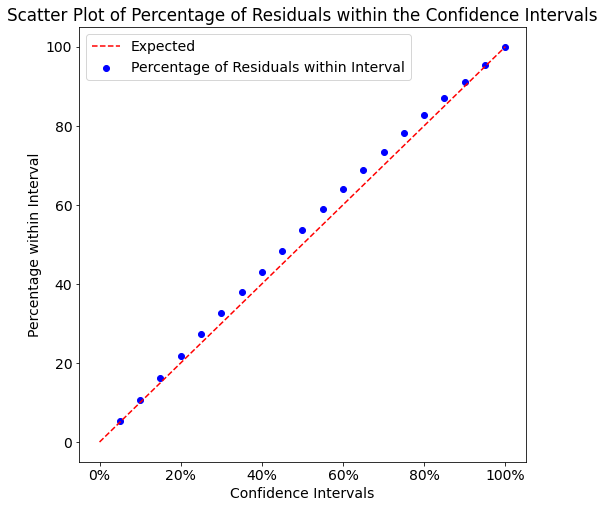

In [87]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Diagonal Covariance Matrix (Common branches for separate turbines)

In [88]:
def create_model_multivariate_gaussian_only_diagonal_common(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []
        
    h1 = Dense(100, activation='relu')(inputs)
    h2 = Dense(50, activation='relu')(h1)
    h3 = Dense(30, activation='relu')(h2)
    
    for i in range(d):
        out = Dense(2)(h3)
        outs.append(out)


    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal_common = create_model_multivariate_gaussian_only_diagonal_common(d, (X_train_mult.shape[1],), MODELS_SEED)

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 204)]                0         []                            
                                                                                                  
 dense_69 (Dense)            (None, 100)                  20500     ['input_9[0][0]']             
                                                                                                  
 dense_70 (Dense)            (None, 50)                   5050      ['dense_69[0][0]']            
                                                                                                  
 dense_71 (Dense)            (None, 30)                   1530      ['dense_70[0][0]']            
                                                              

2055/2055 [==============================] - 4s 2ms/step - loss: 26.9807 - val_loss: 27.1235
Epoch 45/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.9554 - val_loss: 27.1323
Epoch 46/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.9360 - val_loss: 27.1048
Epoch 47/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.9060 - val_loss: 27.1957
Epoch 48/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.8904 - val_loss: 27.1319
Epoch 49/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.8529 - val_loss: 27.1291
Epoch 50/100
2055/2055 [==============================] - 5s 2ms/step - loss: 26.8390 - val_loss: 27.1985
Epoch 51/100
2055/2055 [==============================] - 5s 3ms/step - loss: 26.8218 - val_loss: 27.0821
Epoch 52/100
2055/2055 [==============================] - 4s 2ms/step - loss: 26.8238 - val_loss: 26.8593
Epoch 53/100
2055/2055 [==============================] - 4

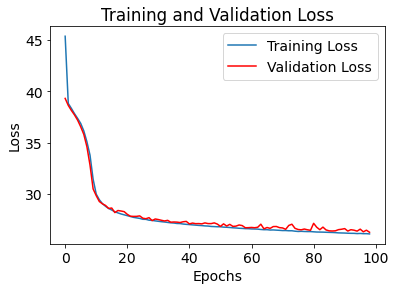

In [89]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_only_diagonal.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal_common,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)
    
    plot_loss_history(history)

In [90]:
model_multivariate_gaussian_only_diagonal_common.load_weights("saved_models/model_multivariate_gaussian_only_diagonal.keras")

In [91]:
model_multivariate_gaussian_only_diagonal_common.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 1s 1ms/step - loss: 26.2689


26.268869400024414

In [92]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 35.151
Test RMSE: 35.851
Train MAE: 21.667
Test MAE: 22.264
Percentage of Train Data Points within 99.00% CI: 98.70%
Percentage of Test Data Points within 99.00% CI: 98.33%


In [93]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

Turbine #1 - RMSE: 34.93082556306131
Turbine #2 - RMSE: 36.31118367000659
Turbine #3 - RMSE: 37.76697056588751
Turbine #4 - RMSE: 35.28873594325064
Turbine #5 - RMSE: 35.03686472855411
Turbine #6 - RMSE: 35.69104266194696


Turbine #1:


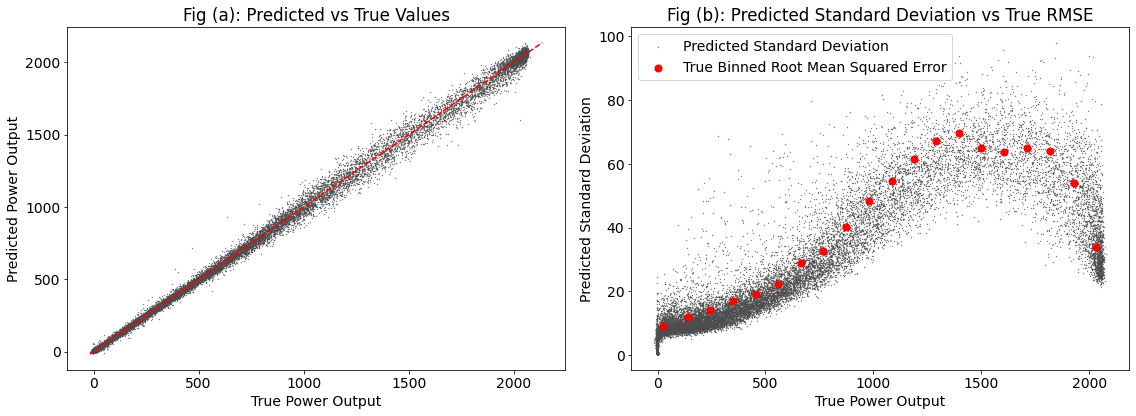

Turbine #2:


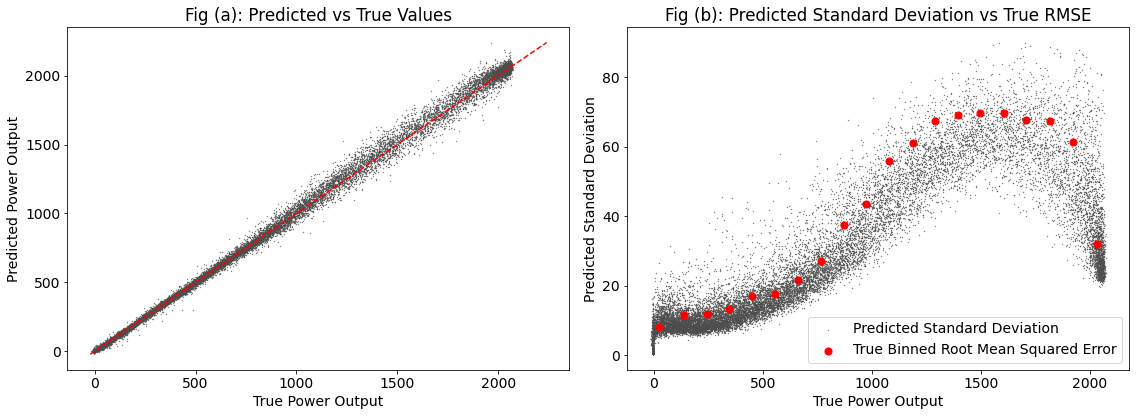

Turbine #3:


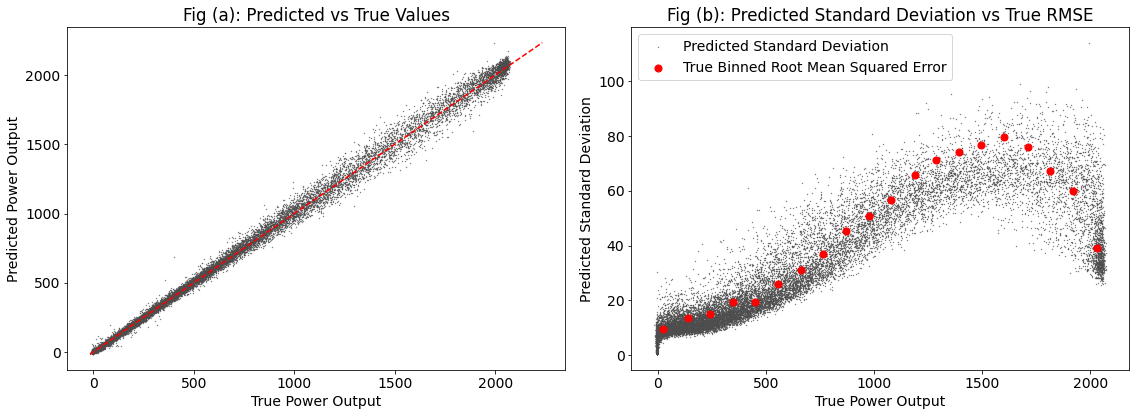

Turbine #4:


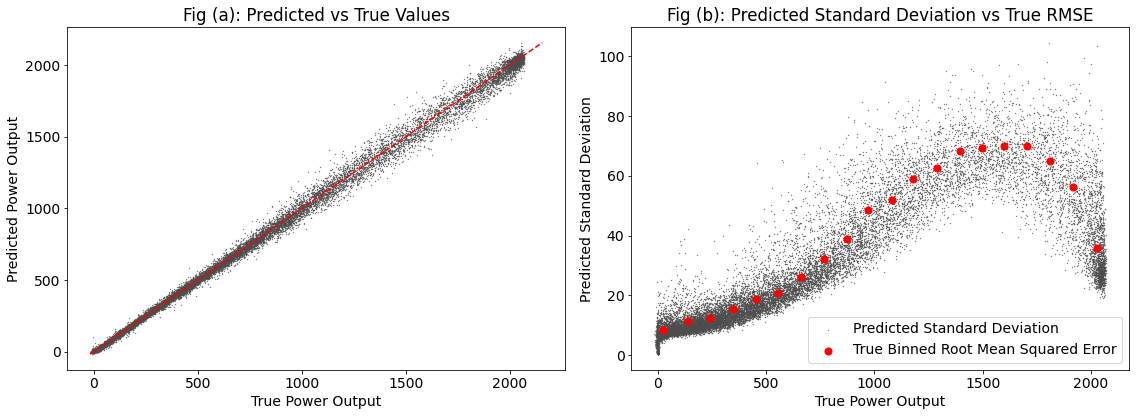

Turbine #5:


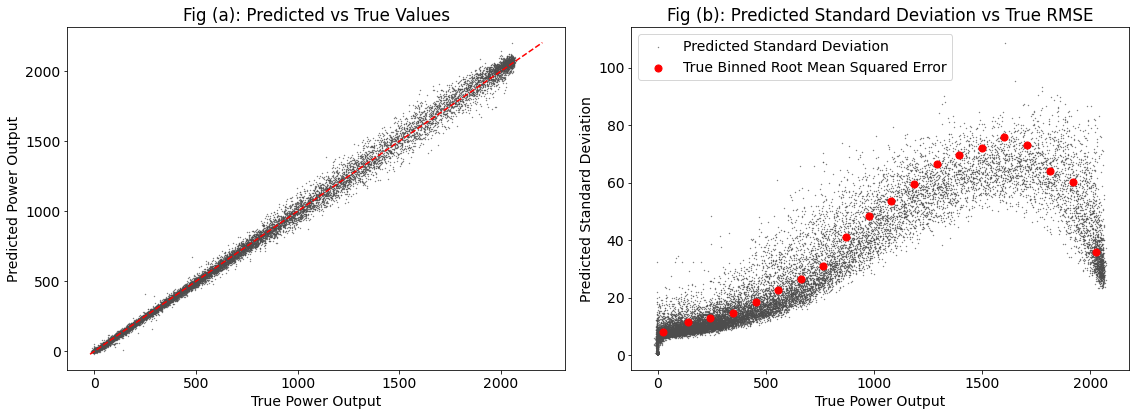

Turbine #6:


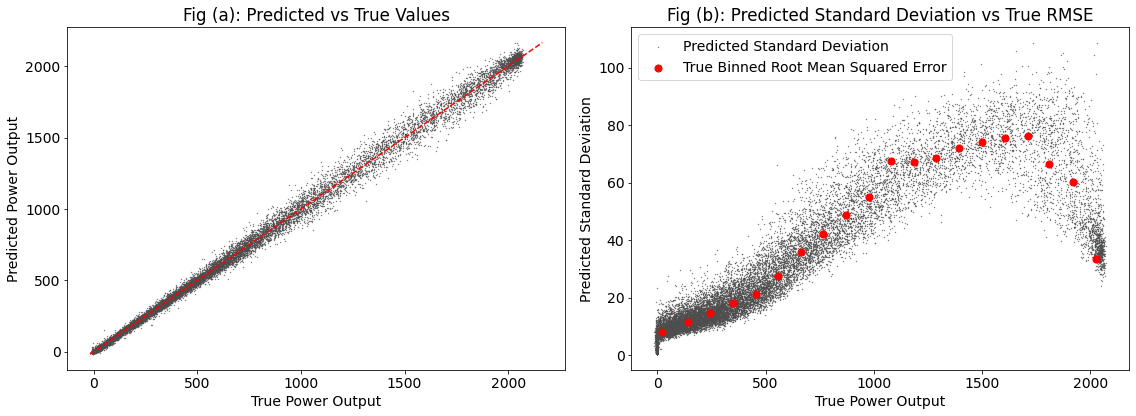

In [94]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


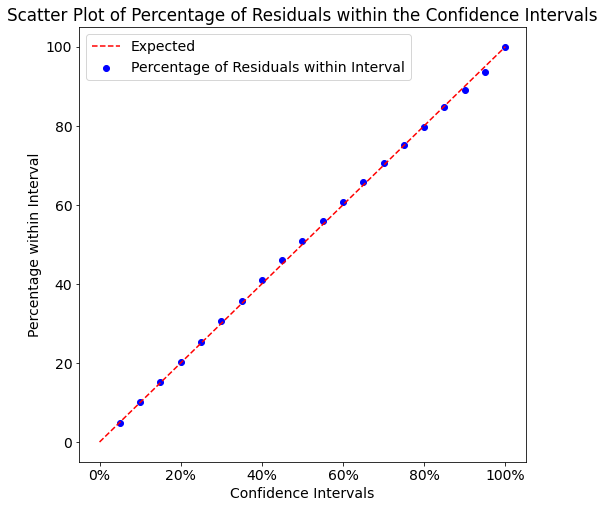

Turbine #2:


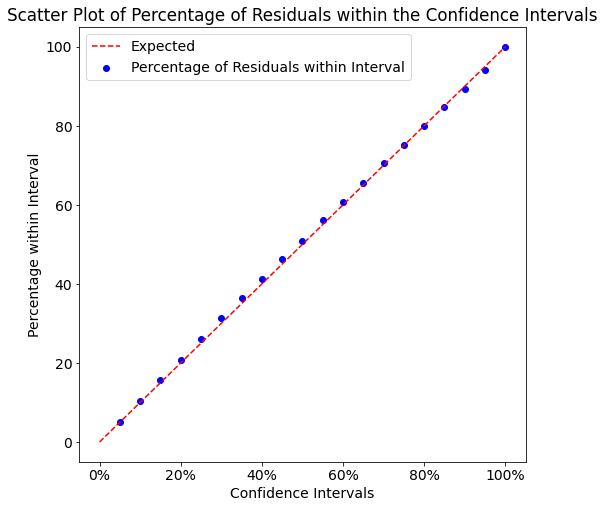

Turbine #3:


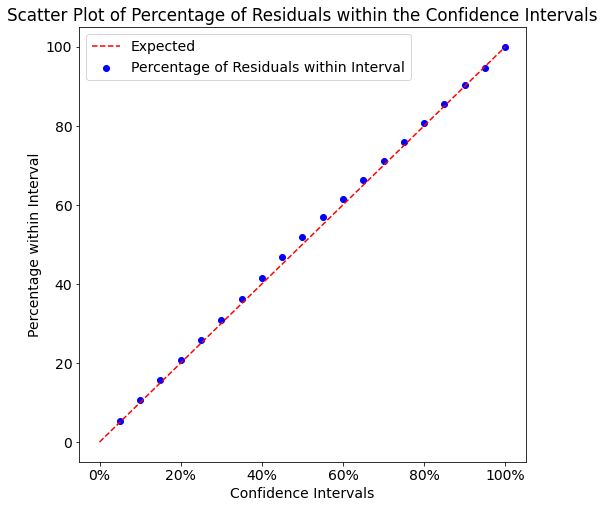

Turbine #4:


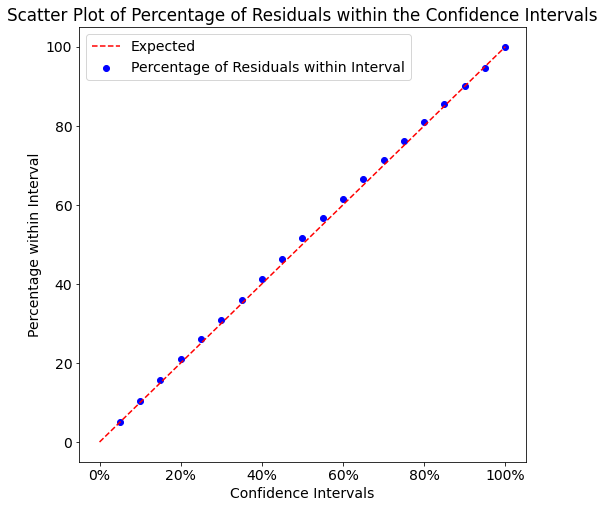

Turbine #5:


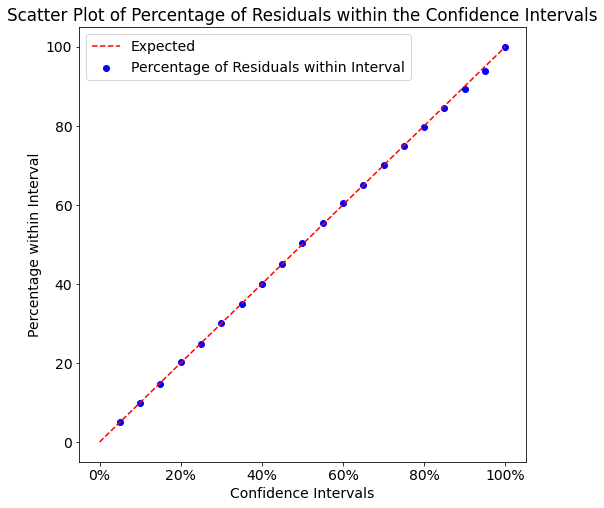

Turbine #6:


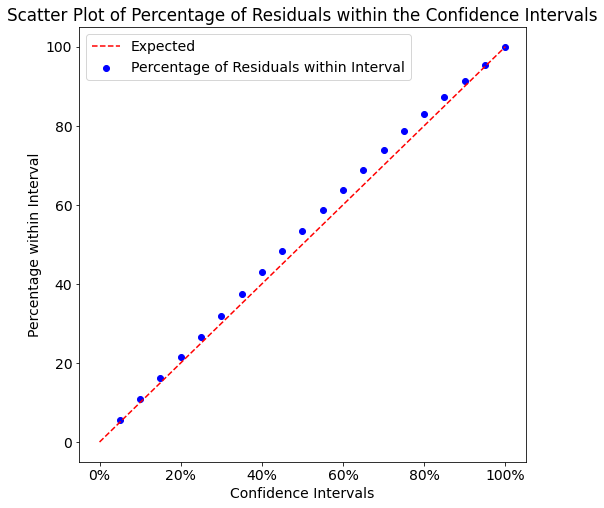

In [95]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [118]:
def create_model_multivariate_gaussian_with_covariance(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)

    h1_mean = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_mean = BatchNormalization()(Dense(70, activation='relu')(h1_mean))
    h3_mean = BatchNormalization()(Dense(50, activation='relu')(h2_mean))
    
    h1_cov = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_cov = BatchNormalization()(Dense(70, activation='relu')(h1_cov))
    h3_cov = BatchNormalization()(Dense(50, activation='relu')(h2_cov))
    
    out_mean = Dense(d, activation='linear')(h3_mean)
    out_cov = Dense(tfp.layers.MultivariateNormalTriL.params_size(d) - d)(h3_cov)
    
    # Concatenate mean and lower triangular part of the covariance matrix
    concatenated_outputs = Concatenate()([out_mean, out_cov])
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_covariance_normal_softplus(t[:, :d], t[:, d:], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001, clipnorm=100),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],), MODELS_SEED)

Model: "multivariate_gaussian_with_covariance"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 204)]                0         []                            
                                                                                                  
 dense_94 (Dense)            (None, 150)                  30750     ['input_12[0][0]']            
                                                                                                  
 dense_97 (Dense)            (None, 150)                  30750     ['input_12[0][0]']            
                                                                                                  
 batch_normalization_12 (Ba  (None, 150)                  600       ['dense_94[0][0]']            
 tchNormalization)                                            

2055/2055 [==============================] - 7s 3ms/step - loss: 31.1768 - val_loss: 29.3287
Epoch 28/100
2055/2055 [==============================] - 7s 3ms/step - loss: 31.2134 - val_loss: 29.5583
Epoch 29/100
2055/2055 [==============================] - 8s 4ms/step - loss: 31.0810 - val_loss: 29.5173
Epoch 30/100
2055/2055 [==============================] - 9s 4ms/step - loss: 31.0809 - val_loss: 29.7613
Epoch 31/100
2055/2055 [==============================] - 7s 3ms/step - loss: 31.0304 - val_loss: 29.5405
Epoch 32/100
2055/2055 [==============================] - 7s 4ms/step - loss: 30.9805 - val_loss: 29.4796
Epoch 33/100
2055/2055 [==============================] - 7s 3ms/step - loss: 31.0343 - val_loss: 29.5217
Epoch 34/100
2055/2055 [==============================] - 7s 3ms/step - loss: 30.9408 - val_loss: 29.3618
Epoch 35/100
2055/2055 [==============================] - 7s 3ms/step - loss: 30.9169 - val_loss: 29.1171
Epoch 36/100
2055/2055 [==============================] - 7

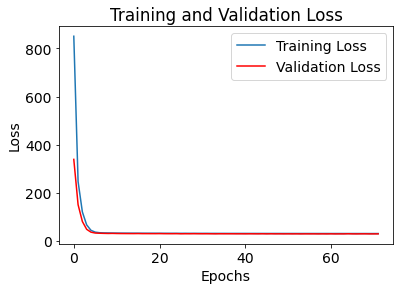

In [119]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_with_covariance.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_with_covariance,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)

    plot_loss_history(history)

In [120]:
model_multivariate_gaussian_with_covariance.load_weights("saved_models/model_multivariate_gaussian_with_covariance.keras")

In [121]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

571/571 [==============================] - 1s 2ms/step - loss: 28.7781


28.778104782104492

In [122]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

Train RMSE: 63.928
Test RMSE: 64.600
Train MAE: 39.058
Test MAE: 39.784
Percentage of Train Data Points within 99.00% CI: 99.97%
Percentage of Test Data Points within 99.00% CI: 99.96%


In [123]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

turbine # 1 - RMSE: 67.7054125600166
turbine # 2 - RMSE: 68.13969416124286
turbine # 3 - RMSE: 74.81691254533425
turbine # 4 - RMSE: 60.343991513369986
turbine # 5 - RMSE: 61.84994219767319
turbine # 6 - RMSE: 52.41701994366864


Turbine #1:


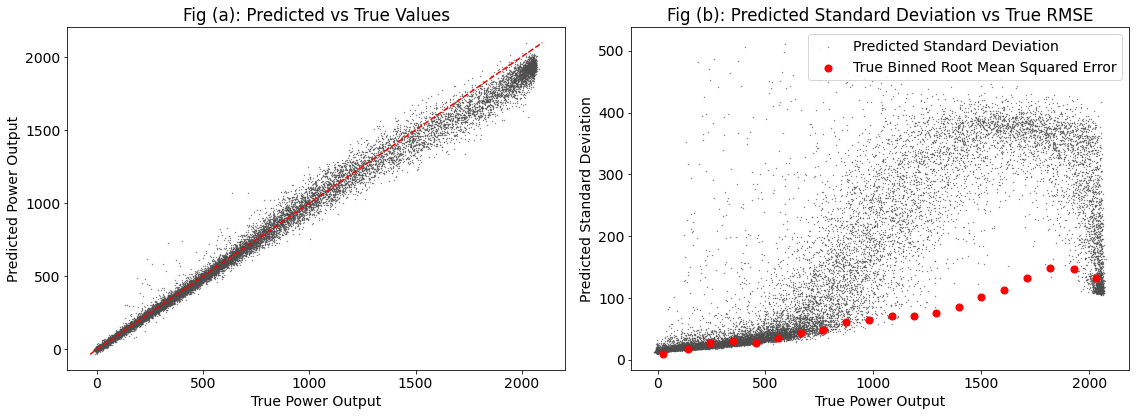

Turbine #2:


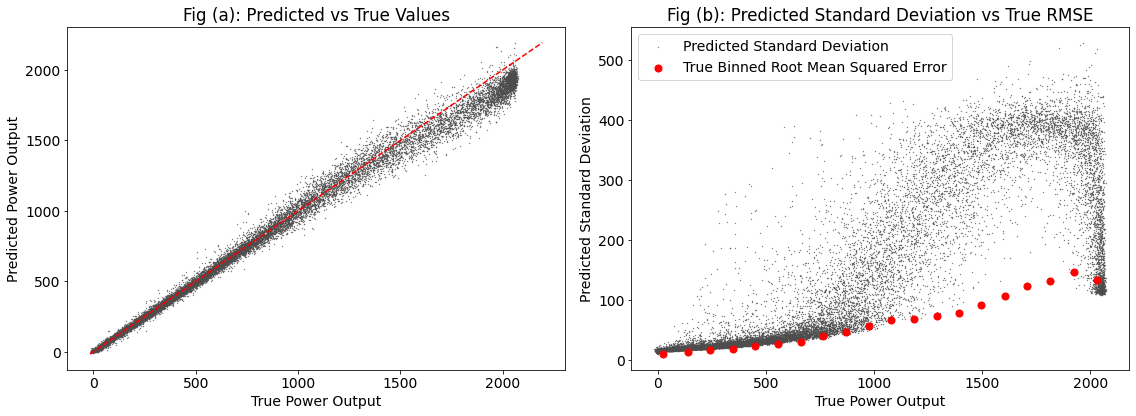

Turbine #3:


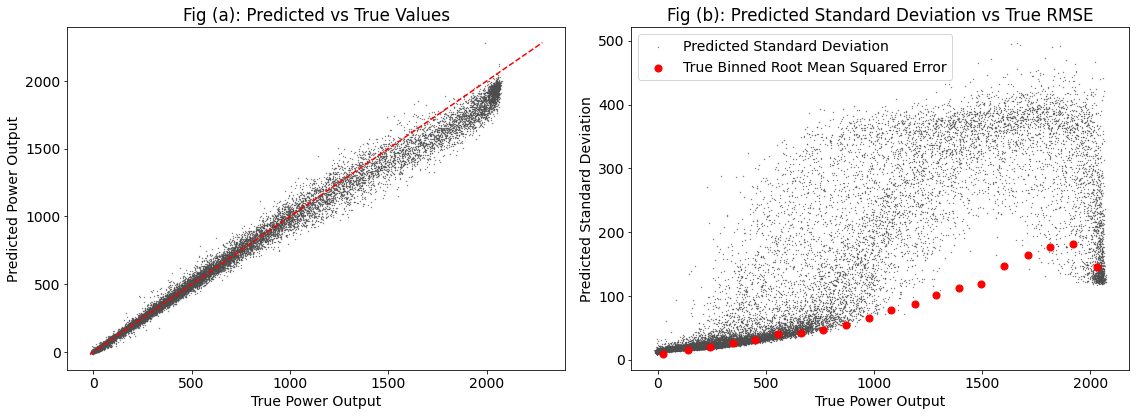

Turbine #4:


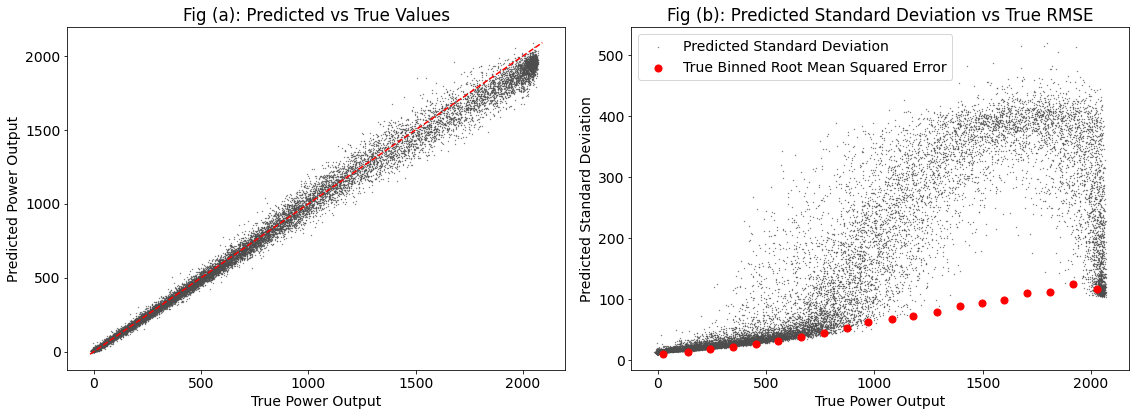

Turbine #5:


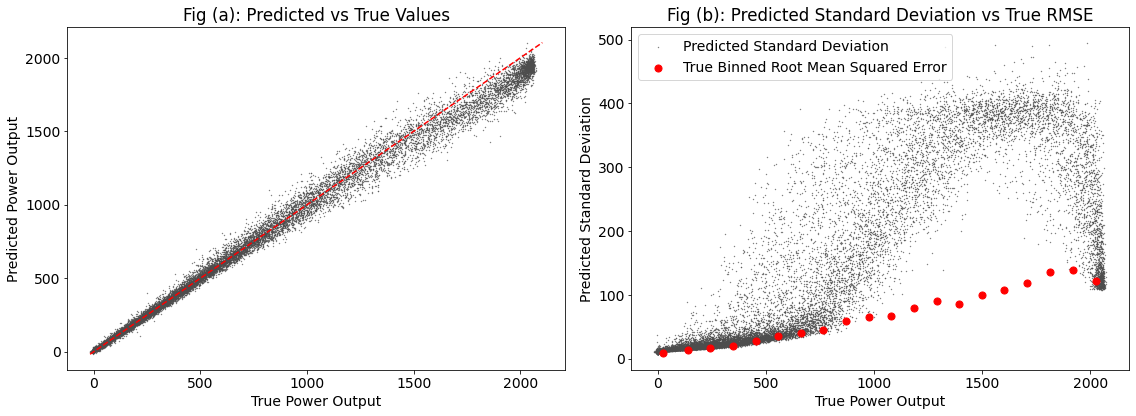

Turbine #6:


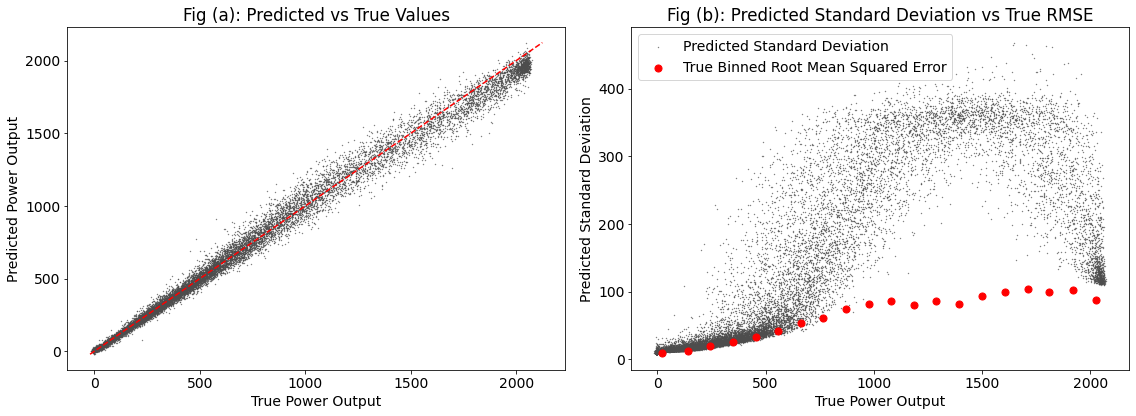

In [124]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

Turbine #1:


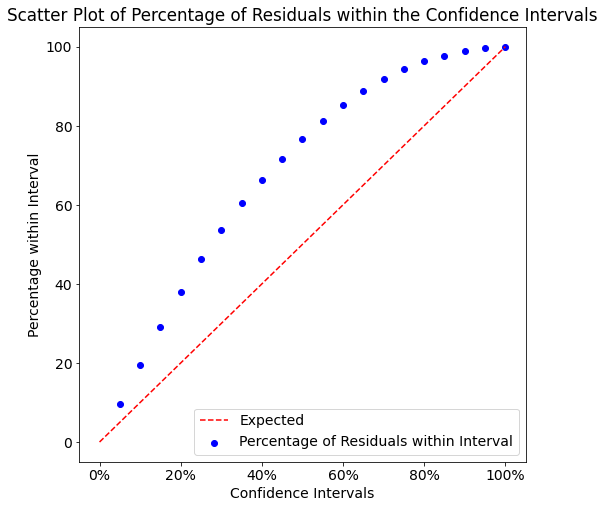

Turbine #2:


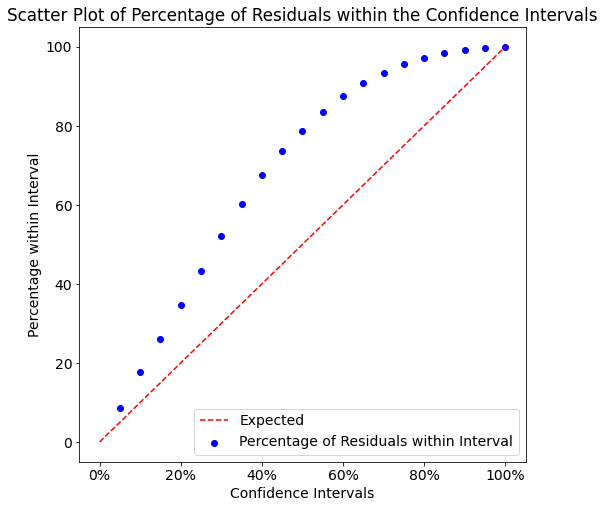

Turbine #3:


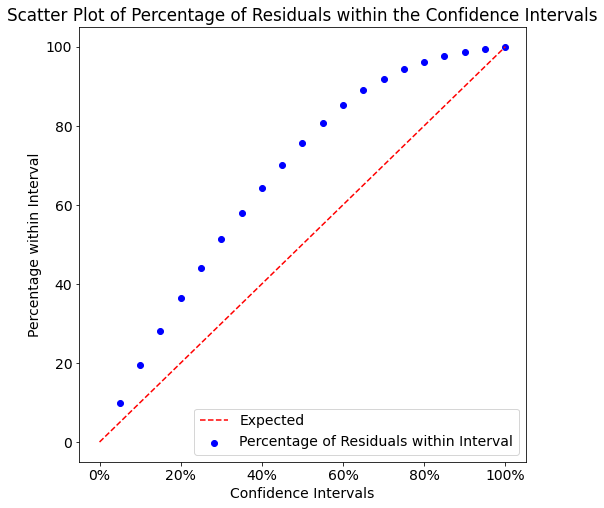

Turbine #4:


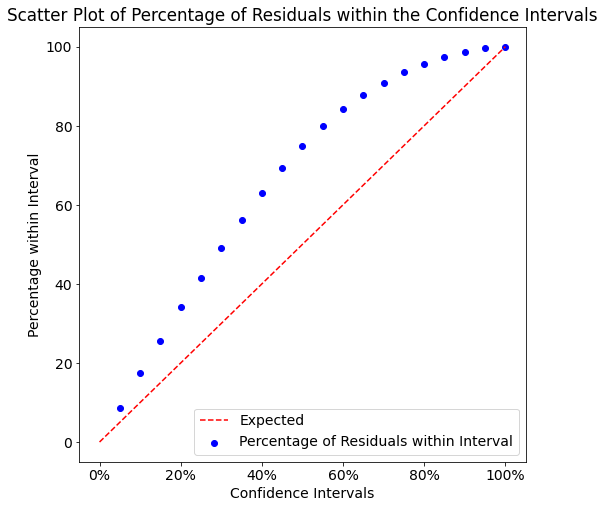

Turbine #5:


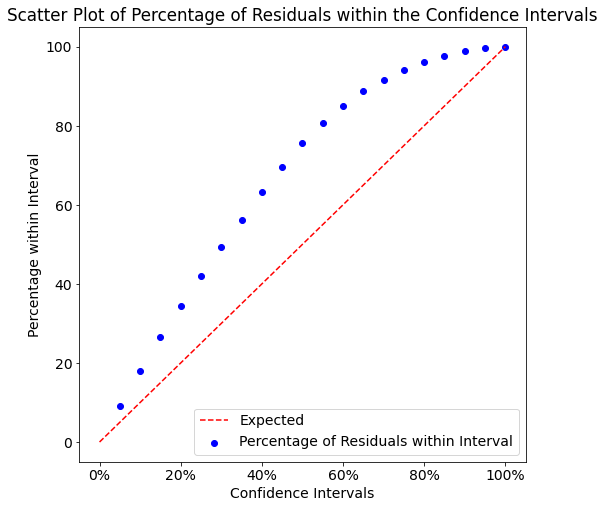

Turbine #6:


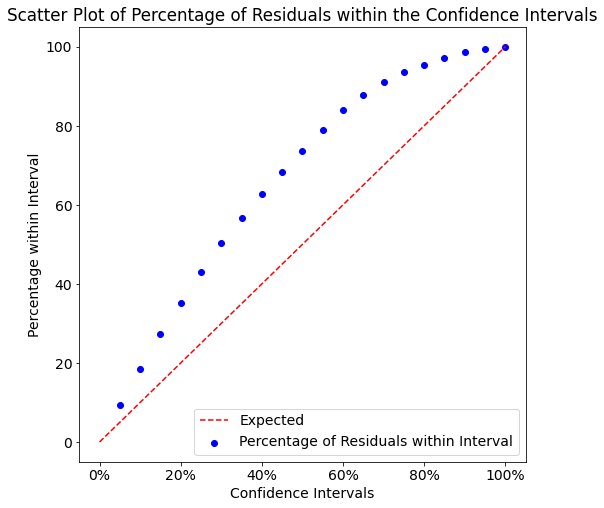

In [125]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow for sufficiently reduced predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 

## Results

In [126]:
# Print metric results for all trained models
for model_name, res in results.items():
    print("Model: ", model_name)
    for metric, value in res.items():
        print(f"{metric:50} {value}")
    print("\n")

Model:  Non-probabilistic MLP
Test Root Mean Squared Error (RMSE):               28.03110894265994
Test Mean Absolute Error (MAE):                    16.764529132294484
Percentage of Test Data Points within 99.00% CI:   96.25102304828788


Model:  Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Test Root Mean Squared Error (RMSE):               124.92549523006788
Test Mean Absolute Error (MAE):                    92.37026089787858
Percentage of Test Data Points within 99.00% CI:   17.168730364073184


Model:  Epistemic Uncertainty BNN (Flipout)
Test Root Mean Squared Error (RMSE):               30.08060578812864
Test Mean Absolute Error (MAE):                    18.492418262060355
Percentage of Test Data Points within 99.00% CI:   24.5689996567838


Model:  Aleatoric & Epistemic Uncertainty BNN (Flipout)
Test Root Mean Squared Error (RMSE):               30.303031139075994
Test Mean Absolute Error (MAE):                    16.562551088216136
Percentage of Test Data Points within 99.0

### Deep Neural Network with Gaussian Output (Joint Submodels) - Averaged over Seeds

We average our proposed model over 5 different random seed for initializing the vector weight to show that our model is robust to the randomness of weight initialization. We demonstrate this by showing a very low standard deviation over the sample set.

In [127]:
if False:
    rmses = []
    maes = []
    percentages = []
    NUM_SEED = 5

    for seed in range(NUM_SEED):
        model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, seed)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/model_mlp_gaussian_joint_{seed}.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
        history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

        z_value = stats.norm.ppf((1 + CONFIDENCE_INTERVAL) / 2)

        y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()
        y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = np.sqrt(mean_absolute_error(y_test, y_test_pred))

        test_lower_bound = y_test_pred - z_value * y_test_stddevs
        test_upper_bound = y_test_pred + z_value * y_test_stddevs

        test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))
        test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

        rmses.append(test_rmse)
        maes.append(test_mae)
        percentages.append(test_percentage_within_interval)
        
    

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 34)]                 0         []                            
                                                                                                  
 dense_102 (Dense)           (None, 100)                  3500      ['input_13[0][0]']            
                                                                                                  
 dense_103 (Dense)           (None, 80)                   8080      ['dense_102[0][0]']           
                                                                                                  
 dense_104 (Dense)           (None, 40)                   3240      ['dense_103[0][0]']           
                                                                                            

4262/4262 [==============================] - 7s 2ms/step - loss: 3.7684 - val_loss: 3.7643
Epoch 52/100
4262/4262 [==============================] - 6s 2ms/step - loss: 3.7603 - val_loss: 3.7632
Epoch 53/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7572 - val_loss: 3.8072
Epoch 54/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7568 - val_loss: 3.7956
Epoch 55/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7530 - val_loss: 3.7982
Epoch 56/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7531 - val_loss: 4.0780
Epoch 57/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7518 - val_loss: 3.8514
Epoch 58/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7479 - val_loss: 3.9950
Epoch 59/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7469 - val_loss: 3.8745
Epoch 60/100
4262/4262 [==============================] - 8s 2ms/step - loss:

4262/4262 [==============================] - 7s 2ms/step - loss: 3.9144 - val_loss: 4.0957
Epoch 21/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.9063 - val_loss: 3.9164
Epoch 22/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8936 - val_loss: 4.0236
Epoch 23/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8872 - val_loss: 3.8787
Epoch 24/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.8773 - val_loss: 3.8859
Epoch 25/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8656 - val_loss: 3.8883
Epoch 26/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8610 - val_loss: 4.0450
Epoch 27/100
4262/4262 [==============================] - 18s 4ms/step - loss: 3.8503 - val_loss: 3.8638
Epoch 28/100
4262/4262 [==============================] - 17s 4ms/step - loss: 3.8450 - val_loss: 3.8411
Epoch 29/100
4262/4262 [==============================] - 8s 2ms/step - los

                                                                                                  
 concatenate_15 (Concatenat  (None, 2)                    0         ['dense_122[0][0]',           
 e)                                                                  'dense_124[0][0]']           
                                                                                                  
 dense_125 (Dense)           (None, 2)                    6         ['concatenate_15[0][0]']      
                                                                                                  
 distribution_lambda_11 (Di  ((None, 1),                  0         ['dense_125[0][0]']           
 stributionLambda)            (None, 1))                                                          
                                                                                                  
Total params: 16508 (64.48 KB)
Trainable params: 16508 (64.48 KB)
Non-trainable params: 0 (0.00 Byte)
_______

4262/4262 [==============================] - 7s 2ms/step - loss: 3.7288 - val_loss: 3.8209
Epoch 69/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7300 - val_loss: 3.8041
Epoch 70/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.7294 - val_loss: 4.0631
Epoch 71/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.7315 - val_loss: 3.8179
Epoch 72/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7211 - val_loss: 3.7801
Epoch 73/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7243 - val_loss: 3.7576
Epoch 74/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7188 - val_loss: 3.7782
Epoch 75/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.7205 - val_loss: 3.7723
Epoch 76/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.7216 - val_loss: 3.8273
Epoch 77/100
4262/4262 [==============================] - 7s 2ms/step - loss:

4262/4262 [==============================] - 8s 2ms/step - loss: 3.9498 - val_loss: 3.9980
Epoch 19/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.9368 - val_loss: 3.9546
Epoch 20/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.9296 - val_loss: 4.0280
Epoch 21/100
4262/4262 [==============================] - 12s 3ms/step - loss: 3.9190 - val_loss: 3.8637
Epoch 22/100
4262/4262 [==============================] - 10s 2ms/step - loss: 3.9075 - val_loss: 4.1221
Epoch 23/100
4262/4262 [==============================] - 10s 2ms/step - loss: 3.9038 - val_loss: 3.8903
Epoch 24/100
4262/4262 [==============================] - 9s 2ms/step - loss: 3.8916 - val_loss: 3.8865
Epoch 25/100
4262/4262 [==============================] - 7s 2ms/step - loss: 3.8876 - val_loss: 3.9029
Epoch 26/100
4262/4262 [==============================] - 8s 2ms/step - loss: 3.8784 - val_loss: 3.9471
Epoch 27/100
4262/4262 [==============================] - 7s 2ms/step - lo

KeyboardInterrupt: 

In [ ]:
if TRAIN == True:
    print(f"Mean of RMSEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of RMSEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of MAEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of MAEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).std()}")

As predicted, the RMSE is inline with what we had for a single seed, moreover, the standard deviation is very low. This shows how our model is robust to the randomness of the weight initialization.

## Plots